* Student name: Tamjid Ahsan
* Student pace: Full Time
* Scheduled project review date/time: May 27, 2021, 05:00 PM [DST]
* Instructor name: James Irving
* Blog post URL: TBA

# INTRODUCTION

The garment industry one of the highly labor-intensive industries that needs large number of human resources to efficient and keep up with demand for garment products across the globe. Because of this inherent dependency on human capital, the production of a garment company comprehensively relies on the productivity of the employees in different departments. Often actual productivity of the garment employees is not in line with targeted productivity that was set. This is a high priority for a organization to achieve deadline and maximize profit by ensuring proper utilization of resources. When any productivity gap occurs, the company faces a huge loss in production.<br>


# BUSINESS PROBLEM

A garment production pipeline consists of a handful of sequential processes, e.g., designing, sample confirmation, sourcing and merchandising, lay planning, marker planning, spreading and cutting, sewing, washing, finishing, and packaging, and then exporting if the order is a international one. An efficient garment production always consists of a line plan with explicit details of when the production will be started, how many pieces are expected, and when the order needs to be completed. To complete a whole production within a target time, these sequential processes need to be to performed efficiently. In order to meet the production goals, the associated industrial engineers strategically set a targeted productivity value against each working team in the manufacturing process. However, it is a common scenario that the actual productivity does not align with the target for several factors, both internal and external.



<br>
I shall use various machine learning techniques for predicting the productivity of the garment employees based on their previous data of internal factors.

<br> More specifically:
- Predict bad performance of workers. Optimize model for precision.
    - Focus on predicting bad performance, don't want to miss much of those. 
    - Focus on maximizing true negatives and minimizing false positives while tackling model overfitting.
    
<br>
<img src="./assets/image.gif"
     alt="head"
     style="float: center; margin-center: 2px;">

# IMPORTS

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# all this codes are displayed in the appendix of the notebook
# custom functions and packages loader
import imports_and_functions as fun
from imports_and_functions.packages import *

# notebook styling packages
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks='True', grid='False')
## to reset to default theme
# jtplot.reset()

# OBTAIN

The data is obtained from <i>UCI Machine Learning Repository</i>, titled <b>"Productivity Prediction of Garment Employees Data Set"</b> by [Abdullah Al Imran](abdalimran@gmail.com)<sup>[1]</sup>. Which can be found [here](https://archive.ics.uci.edu/ml/datasets/Productivity+Prediction+of+Garment+Employees#). A copy of the data is in this repository at `/data/garments_worker_productivity.csv`.

The collected dataset contains the production data of the sewing and finishing department for three months from January 2015 to March 2015 of a renowned garment manufacturing company in Bangladesh<sup>[2]</sup>. The dataset consists of 1197 instances and includes 13 attributes.



<br>
Features with explanation.

 - `date`: Date in MM-DD-YYYY format.
 - `day`: Day of the Week.
 - `quarter`: A portion of the month. A month was divided into four quarters.
 - `department`: Associated department with the instance.
 - `team_no`: Associated team number with the instance.
 - `no_of_workers`: Number of workers in each team.
 - `no_of_style_change`: Number of changes in the style of a particular product.
 - `targeted_productivity`: Targeted productivity set by the Authority for each team for each day.
 - `smv`: Standard Minute Value, it is the allocated time for a task.
 - `wip`: Work in progress. Includes the number of unfinished items for products.
 - `over_time`: Represents the amount of overtime by each team in minutes.
 - `incentive`: Represents the amount of financial incentive (in BDT<sup>[3]</sup>) that enables or motivates a particular course of action.
 - `idle_time`: The amount of time when the production was interrupted due to several reasons.
 - `idle_men`: The number of workers who were idle due to production interruption.
 - `actual_productivity`: The actual % of productivity that was delivered by the workers. It ranges from 0-1<sup>[4]</sup>.


<br>


___
[1]  ```Rahim, M. S., Imran, A. A., & Ahmed, T. (2021). Mining the Productivity Data of Garment Industry. International Journal of Business Intelligence and Data Mining, 1(1), 1. ```
<br>[2] Bangladesh is a developing country which is the second largest apparel exporting country in the world.
<br>[3] 1 USD = 84.83 BDT, as of May 23,2021. Check [here](https://www.bb.org.bd/en/index.php/econdata/exchangerate) from Bangladesh Bank.
<br>[4] Measured by production production engineers of the organization. Methodology of this calculation is not public.


<br>
<div>Reference:
<p class="normal">@article{Rahim_2021,
<br>	doi = {10.1504/ijbidm.2021.10028084},
<br>	url = {<a href="https://doi.org/10.1504%2Fijbidm.2021.10028084">[Web Link]</a>},
<br>	year = 2021,
<br>	publisher = {Inderscience Publishers},
<br>	volume = {1},
<br>	number = {1},
<br>	pages = {1},
<br>	author = {Md Shamsur Rahim and Abdullah Al Imran and Tanvir Ahmed},
<br>	title = {Mining the Productivity Data of Garment Industry},
<br>	journal = {International Journal of Business Intelligence and Data Mining}
<br>}
</p></div>

# SCRUB & EXPLORE

## data

In [3]:
# this dataset is also available for use from the following url.
# this analysis can be also performed by directly loading data from UCI.
# df = pd.read_csv(
#     'https://archive.ics.uci.edu/ml/machine-learning-databases/00597/garments_worker_productivity.csv'
# )

In [4]:
# loading data from local source
df = pd.read_csv('./data/garments_worker_productivity.csv')

In [5]:
# 10 sample of the dataset. Data loading successful.
df.sample(10)

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
797,2/16/2015,Quarter3,finishing,Monday,5,0.75,4.15,NaN,1200,0,0.0,0,0,10.0,0.629417
693,2/10/2015,Quarter2,finishing,Tuesday,2,0.80,3.94,NaN,2160,0,0.0,0,0,18.0,0.966759
530,1/31/2015,Quarter5,finishing,Saturday,11,0.65,3.94,NaN,600,0,0.0,0,0,5.0,0.971867
325,1/19/2015,Quarter3,sweing,Monday,2,0.70,22.94,1006.0,10170,38,0.0,0,0,56.5,0.750518
1055,3/4/2015,Quarter1,sweing,Wednesday,3,0.80,29.40,1169.0,6840,63,0.0,0,0,57.0,0.800333
1036,3/3/2015,Quarter1,finishing,Tuesday,8,0.75,4.60,NaN,3360,0,0.0,0,0,8.0,0.702778
890,2/23/2015,Quarter4,sweing,Monday,5,0.80,30.10,541.0,7140,38,0.0,0,0,59.0,0.800137
470,1/27/2015,Quarter4,sweing,Tuesday,9,0.70,29.12,1294.0,6960,50,0.0,0,0,58.0,0.700386
597,2/3/2015,Quarter1,finishing,Tuesday,6,0.70,2.90,NaN,960,0,0.0,0,0,8.0,0.495417
945,2/26/2015,Quarter4,sweing,Thursday,7,0.80,30.10,694.0,4080,50,0.0,0,1,59.0,0.800809


In [6]:
df.dtypes

date                      object
quarter                   object
department                object
day                       object
team                       int64
targeted_productivity    float64
smv                      float64
wip                      float64
over_time                  int64
incentive                  int64
idle_time                float64
idle_men                   int64
no_of_style_change         int64
no_of_workers            float64
actual_productivity      float64
dtype: object

Observation:
* every feature has correct data type except `team`.
* `team` is a categorical data which is labeled numerically.

In [7]:
fun.check_NaN(df)

,name,is_null,not_null
0,date,0,1197
1,quarter,0,1197
2,department,0,1197
3,day,0,1197
4,team,0,1197
5,targeted_productivity,0,1197
6,smv,0,1197
7,wip,506,691
8,over_time,0,1197
9,incentive,0,1197


`wip` has NaN values. Those are not missing. For those days where there were no work in progress, data is empty. Those can be safely filled with 0.

In [8]:
fun.check_duplicates(df, verbose=True)

date >> number of uniques: 59
['1/1/2015' '1/3/2015' '1/4/2015' '1/5/2015' '1/6/2015' '1/7/2015'
 '1/8/2015' '1/10/2015' '1/11/2015' '1/12/2015' '1/13/2015' '1/14/2015'
 '1/15/2015' '1/17/2015' '1/18/2015' '1/19/2015' '1/20/2015' '1/21/2015'
 '1/22/2015' '1/24/2015' '1/25/2015' '1/26/2015' '1/27/2015' '1/28/2015'
 '1/29/2015' '1/31/2015' '2/1/2015' '2/2/2015' '2/3/2015' '2/4/2015'
 '2/5/2015' '2/7/2015' '2/8/2015' '2/9/2015' '2/10/2015' '2/11/2015'
 '2/12/2015' '2/14/2015' '2/15/2015' '2/16/2015' '2/17/2015' '2/18/2015'
 '2/19/2015' '2/22/2015' '2/23/2015' '2/24/2015' '2/25/2015' '2/26/2015'
 '2/28/2015' '3/1/2015' '3/2/2015' '3/3/2015' '3/4/2015' '3/5/2015'
 '3/7/2015' '3/8/2015' '3/9/2015' '3/10/2015' '3/11/2015']
____________________________________________________________
quarter >> number of uniques: 5
['Quarter1' 'Quarter2' 'Quarter3' 'Quarter4' 'Quarter5']
____________________________________________________________
department >> number of uniques: 3
['sweing' 'finishing ' 'fini

,name,duplicated,not_duplicated
0,date,1138,59
1,quarter,1192,5
2,department,1194,3
3,day,1191,6
4,team,1185,12
5,targeted_productivity,1188,9
6,smv,1127,70
7,wip,648,549
8,over_time,1054,143
9,incentive,1149,48


* `smv` depends on product.
* `department` has issue with naming
* Value of 'Quarter5' in `quarter` is inconsistent with data description. 

every other feature is clean and coherent.

In [9]:
# looking into `quarter`
df[df.quarter=='Quarter5']

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
498,1/29/2015,Quarter5,sweing,Thursday,2,0.80,22.52,1416.0,6840,113,0.0,0,0,57.0,1.000230
499,1/29/2015,Quarter5,finishing,Thursday,4,0.80,4.30,NaN,1200,0,0.0,0,0,10.0,0.989000
500,1/29/2015,Quarter5,sweing,Thursday,3,0.80,22.52,1287.0,6840,100,0.0,0,0,57.0,0.950186
501,1/29/2015,Quarter5,sweing,Thursday,4,0.80,22.52,1444.0,6900,88,0.0,0,0,57.5,0.900800
502,1/29/2015,Quarter5,sweing,Thursday,10,0.80,22.52,1088.0,6720,88,0.0,0,0,56.0,0.900130
503,1/29/2015,Quarter5,finishing,Thursday,6,0.50,2.90,NaN,1200,0,0.0,0,0,10.0,0.899000
504,1/29/2015,Quarter5,finishing,Thursday,8,0.65,4.15,NaN,960,0,0.0,0,0,8.0,0.877552
505,1/29/2015,Quarter5,finishing,Thursday,11,0.60,2.90,NaN,960,0,0.0,0,0,8.0,0.864583
506,1/29/2015,Quarter5,finishing,Thursday,10,0.80,3.94,NaN,1200,0,0.0,0,0,10.0,0.856950
507,1/29/2015,Quarter5,finishing,Thursday,1,0.75,3.94,NaN,1200,0,0.0,0,0,10.0,0.853667


Those data are for January 29, Thursday; and 31, Saturday of 2015. I can not come up with any rational for this treatment, Thus leaving it at is. Another option is to merge these with `Quarter4`.

In [10]:
df.describe().transpose().round(2).style.format("{0:,.2f}")

,count,mean,std,min,25%,50%,75%,max
team,"1,197.00",6.43,3.46,1.00,3.00,6.00,9.00,12.00
targeted_productivity,"1,197.00",0.73,0.10,0.07,0.70,0.75,0.80,0.80
smv,"1,197.00",15.06,10.94,2.90,3.94,15.26,24.26,54.56
wip,691.00,"1,190.47","1,837.46",7.00,774.50,"1,039.00","1,252.50","23,122.00"
over_time,"1,197.00","4,567.46","3,348.82",0.00,"1,440.00","3,960.00","6,960.00","25,920.00"
incentive,"1,197.00",38.21,160.18,0.00,0.00,0.00,50.00,"3,600.00"
idle_time,"1,197.00",0.73,12.71,0.00,0.00,0.00,0.00,300.00
idle_men,"1,197.00",0.37,3.27,0.00,0.00,0.00,0.00,45.00
no_of_style_change,"1,197.00",0.15,0.43,0.00,0.00,0.00,0.00,2.00
no_of_workers,"1,197.00",34.61,22.20,2.00,9.00,34.00,57.00,89.00


* Can spot unusual low value for `targeted productivity`. Further investigation is required.
* `incentive` has a wide range.
I can further comment on those after I peek into their distribution.

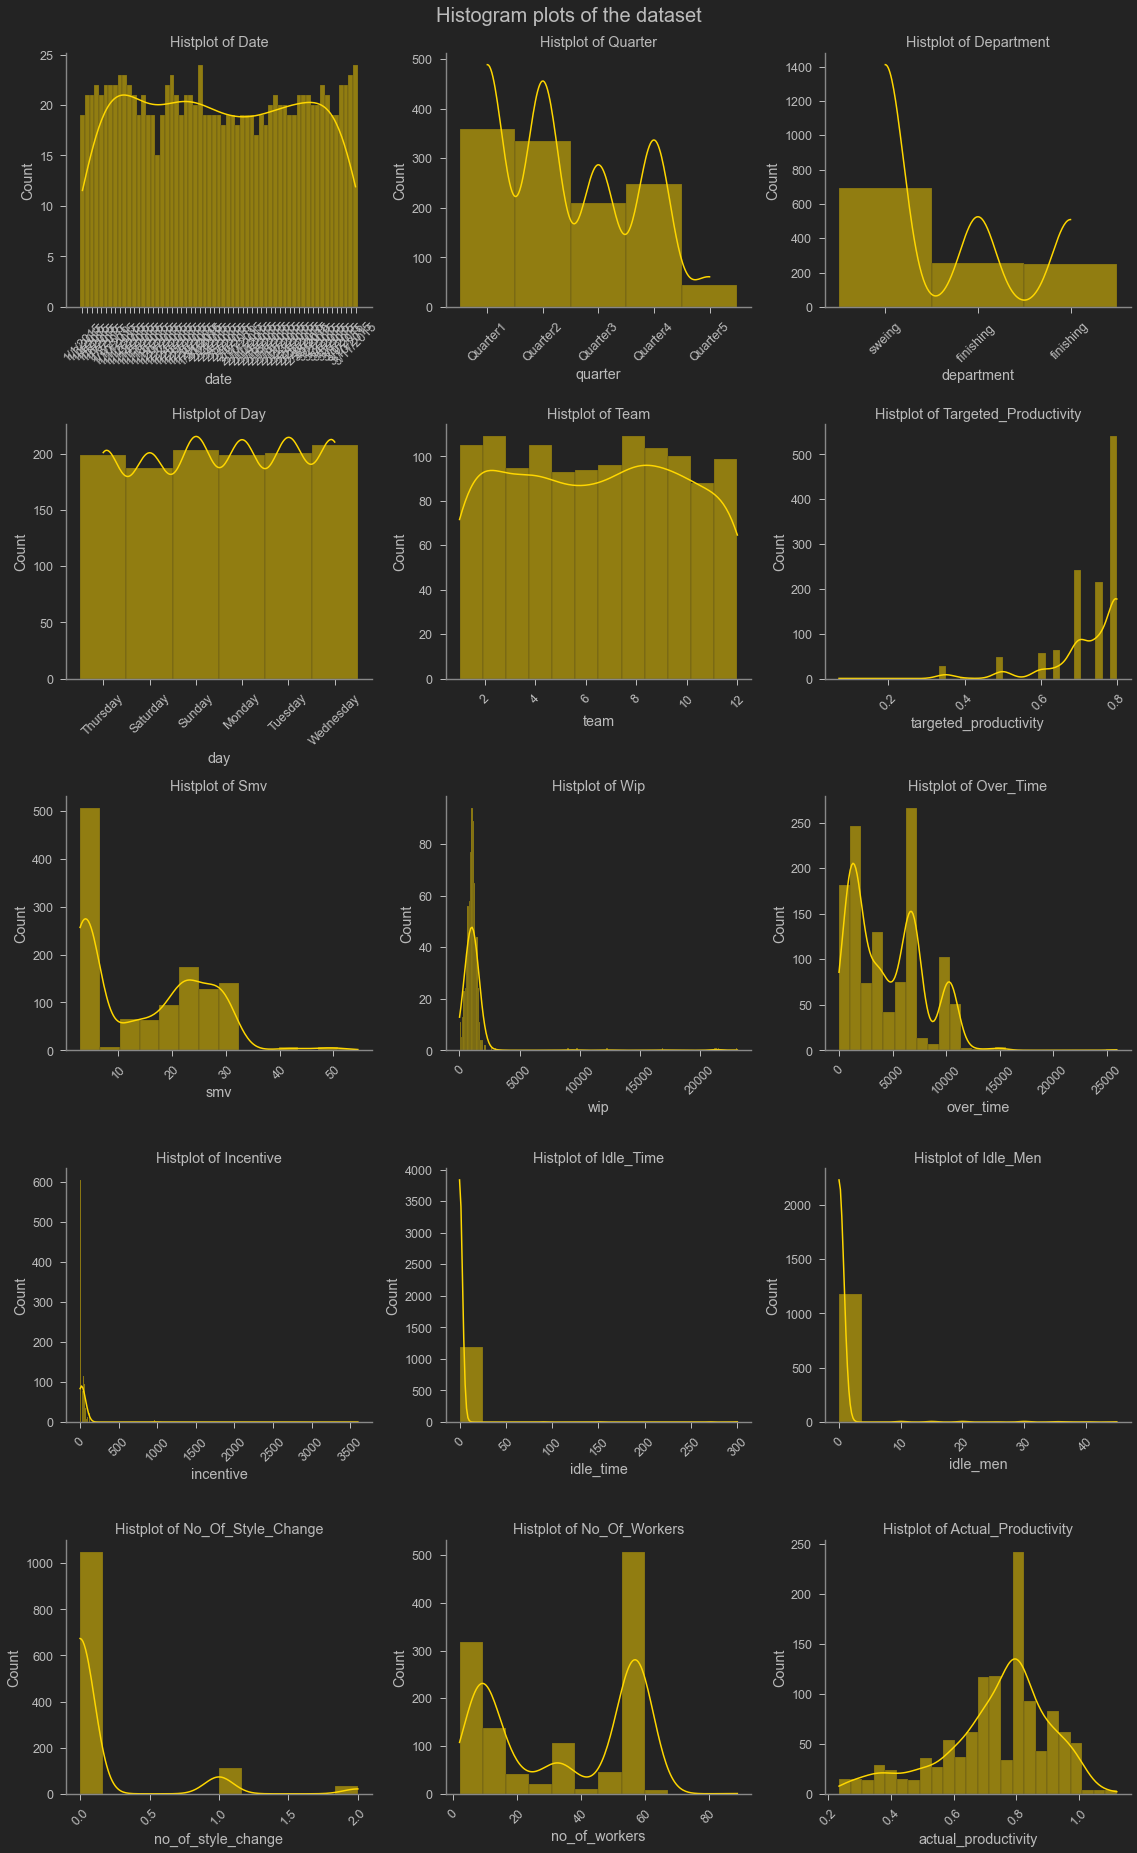

In [11]:
fun.distribution_of_features(df,color_plot='gold')

* None of them are normally distributed.
* Most of them are skewed. e.g., `idle_men`, `idle_time`, `incentive`, `wip`.
* `target` has few regular occurring values.
* `smv`, `overtime` has some very high values

## Feature engineering

### Creating target; `performance`

I am treating this as a binary classification model. For this I am converting `actual_productivity` into a binary class. Logic behind this operation is, if the `actual_productivity` is greater than `targeted_productivity` then its a 1, and 0 otherwise.
I am not encoding in text as most of the model requirs numerical data in target. This eliminates the need for label encoding. And for binary classification this does not create confusion while looking at reports of model performance. 

In [12]:
# binary target class, int
lst = []
for x in zip(df.targeted_productivity, df.actual_productivity):
    # % change in variables
    delta = np.log(x[1] / x[0])
    if delta < 0:
        lst.append(0)
    else:
        lst.append(1)
df['performance'] = lst

In [13]:
# checking for class imbalance
df.performance.value_counts(1)

1    0.730994
0    0.269006
Name: performance, dtype: float64

Straight away I can spot a class imbalance issue. I have to address this later while modeling.

### Cleaning `wip`

In [14]:
# filling NaN's with 0, meaning no wip for that session
df['wip'] = df['wip'].fillna(0)

### Text cleaning in `department` categories 

In [15]:
df['department'].value_counts()

sweing        691
finishing     257
finishing     249
Name: department, dtype: int64

In [16]:
# cleaning spaces
df['department'] = df['department'].str.strip()
# checking
df['department'].value_counts()

sweing       691
finishing    506
Name: department, dtype: int64

### Cleaning `quarter`

In [17]:
# as identified before, cleaning by merging Quarter5 with Quarter4
df.at[df[df.quarter == 'Quarter5'].index, 'quarter'] = 'Quarter4'

In [18]:
# checking
df[df.quarter == 'Quarter5']

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity,performance


### Cleaning `targeted_productivity`

In [19]:
# correcting possible error in data
# according to my plot, I am isolating data to pin point issue
df[df.targeted_productivity<.3]

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity,performance
633,2/5/2015,Quarter1,sweing,Thursday,7,0.07,24.26,1608.0,6960,0,0.0,0,0,58.0,0.522845,1


targeted_productivity stats:
******************************
 0.8	 : mode
 0.73	 : mean
 0.7	 : 25% quantile
******************************


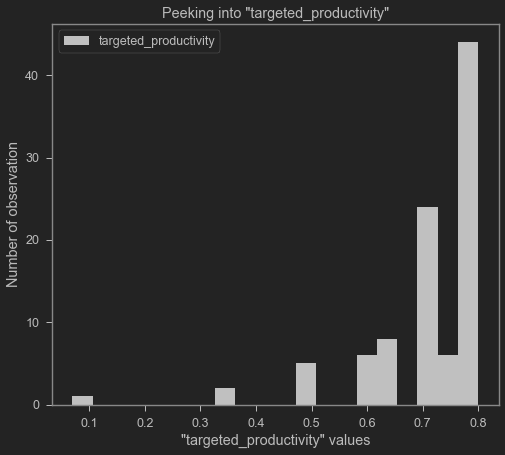

In [20]:
df[df.team == 7]['targeted_productivity'].hist(color='silver',
                                               grid=False,
                                               legend=True,
                                               bins=20)
plt.title('Peeking into "targeted_productivity"')
plt.xlabel('"targeted_productivity" values')
plt.ylabel('Number of observation')

print(f"""targeted_productivity stats:
{'*'*30}
 {df.targeted_productivity.mode()[0]}\t : mode
 {round(df.targeted_productivity.mean(),2)}\t : mean
 {df.targeted_productivity.quantile(.25)}\t : 25% quantile
{'*'*30}""")

From this plot I can safely assume that this a data entry error. Setting a target so low does not make any sense. I am filling this with the 25% quantile .

In [21]:
df.at[df[df.targeted_productivity < .3].index,
      'targeted_productivity'] = df.targeted_productivity.quantile(.25)

df[df.targeted_productivity < .3]

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity,performance


No error remains.

### Drop features

Dropping `date` as this is not useful for modeling and timing is captured in `day` and `quarter` features, `actual_productivity` as this is the target in continuous format.

In [22]:
df.drop(columns=['date', 'actual_productivity'], inplace=True)

### dtype casting

In [23]:
df.dtypes

quarter                   object
department                object
day                       object
team                       int64
targeted_productivity    float64
smv                      float64
wip                      float64
over_time                  int64
incentive                  int64
idle_time                float64
idle_men                   int64
no_of_style_change         int64
no_of_workers            float64
performance                int64
dtype: object

In [24]:
# setting all categorical variabls as 'category'.
df['quarter'] = df['quarter'].astype('category')
df['department'] = df['department'].astype('category')
df['day'] = df['day'].astype('category')
df['team'] = df['team'].astype('category')

In [25]:
df.dtypes

quarter                  category
department               category
day                      category
team                     category
targeted_productivity     float64
smv                       float64
wip                       float64
over_time                   int64
incentive                   int64
idle_time                 float64
idle_men                    int64
no_of_style_change          int64
no_of_workers             float64
performance                 int64
dtype: object

Everything cleaned.

In [26]:
# cleaned dataset for modeling
df

,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,performance
0,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,1
1,Quarter1,finishing,Thursday,1,0.75,3.94,0.0,960,0,0.0,0,0,8.0,1
2,Quarter1,sweing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,1
3,Quarter1,sweing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,1
4,Quarter1,sweing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1192,Quarter2,finishing,Wednesday,10,0.75,2.90,0.0,960,0,0.0,0,0,8.0,0
1193,Quarter2,finishing,Wednesday,8,0.70,3.90,0.0,960,0,0.0,0,0,8.0,0
1194,Quarter2,finishing,Wednesday,7,0.65,3.90,0.0,960,0,0.0,0,0,8.0,0
1195,Quarter2,finishing,Wednesday,9,0.75,2.90,0.0,1800,0,0.0,0,0,15.0,0


### EDA

___

Data preparation for visuals

In [27]:
# custom colour pallate
cust_pal = ['#f22b07', 'lime']
cust_pal2 = ['gold', 'silver']
# dataset for eda
df_eda = df.copy()

# binning data for visuals
#### smv ###
df_eda['smv_bin'] = pd.qcut(x=df_eda.smv,
                            q=4,
                            labels=['quick', 'normal', 'long', 'extra_long'])
#### wip ####
# filling NaN's with 0, meaning no wip for that session
df_eda['wip'] = df_eda['wip'].fillna(0)
# intervals for binning
bins = pd.IntervalIndex.from_tuples([(0, 1), (1, 150), (150, 500), (500, 2500),
                                     (2500, 1e6)],
                                    closed='left')
# binning
wip_size = pd.cut(df_eda['wip'].tolist(), bins=bins)
# naming categories
wip_size.categories = ['no_wip', 'small', 'med', 'large', 'xl']
# appending to df_eda
df_eda['wip_bin'] = wip_size

#### incentive ####
# intervals for binning
bins = pd.IntervalIndex.from_tuples([(0, 30), (30, 80), (80, 500), (500, 2500),
                                     (2500, 1e6)],
                                    closed='left')
# binning
incentive_size = pd.cut(df_eda['incentive'].tolist(), bins=bins)
# naming categories
incentive_size.categories = [
    'no_incentive', 'minor', 'med', 'large', 'generous'
]
# appending to df_eda
df_eda['incentive_bin'] = incentive_size

My rational for binning this features at those interval are explained in details when I explore those more in the following section.

___

#### which department has better performance

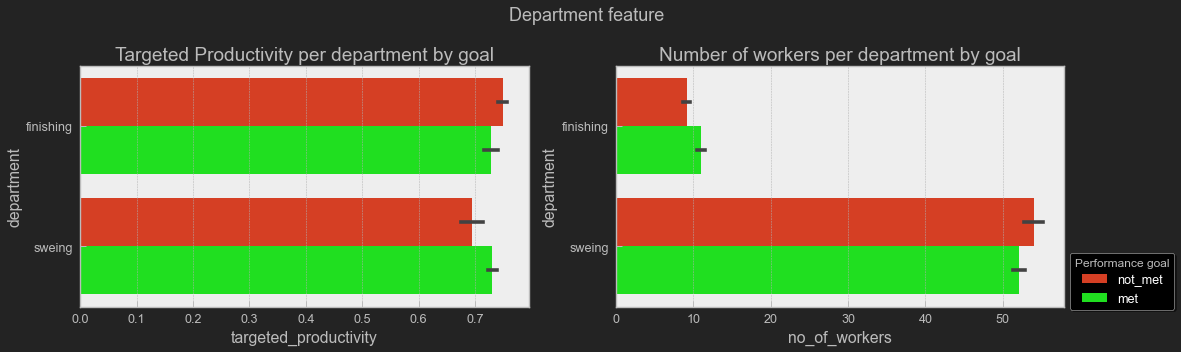

In [28]:
with plt.style.context('bmh'):
    plt.figure(figsize=(16.5, 5))
    plt.subplot(121)
    ax = sns.barplot(data=df_eda,
                     y='department',
                     ci=95,
                     x='targeted_productivity',
                     hue='performance',
                     palette=cust_pal)
    # remove legend
    ax.legend([], [], frameon=False)
    # add legend, ## comment out `remove legend` step and uncomment follwing code to add legend
    # legend_labels, _ = ax.get_legend_handles_labels()
    # ax.legend(
    #     legend_labels,
    #     ['not_met', 'met'],
    #     bbox_to_anchor=(1.26, 1),
    #     title_fontsize=12,
    #     title='Performance')
    ax.set_title('Targeted Productivity per department by goal')

    plt.subplot(122, sharey=ax)
    ax1 = sns.barplot(data=df_eda,
                      y='department',
                      x='no_of_workers',
                      hue='performance',
                      ci=95,
                      palette=cust_pal)
    legend_labels, _ = ax1.get_legend_handles_labels()
    ax1.legend(legend_labels, ['not_met', 'met'],
               title_fontsize=12,labelcolor='white',
               title='Performance goal',facecolor='black',
               bbox_to_anchor=(1.26, .25),
               shadow=True,
               fancybox=True)
    ax1.set_title('Number of workers per department by goal')

    plt.suptitle('Department feature', size=18, weight=4)
    plt.tight_layout()
    plt.show()

Finishing department and sewing department has similar targets and finishing department often fail to meet daily goal. This can be explained by the small size of finishing department. Adding a few workers can be beneficial.

#### productive day of the week

In [29]:
df_eda.day.cat.categories

Index(['Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday'], dtype='object')

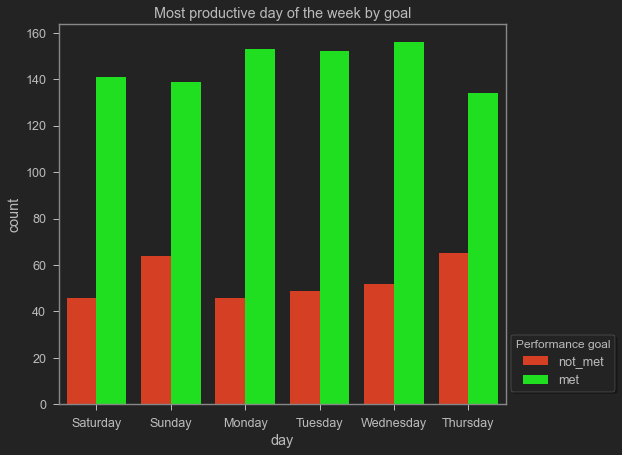

In [30]:
ax1 = sns.countplot(
    data=df_eda,
    hue='performance',
    x='day',
    palette=cust_pal,
    order=['Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday'])
legend_labels, _ = ax1.get_legend_handles_labels()
ax1.legend(legend_labels, ['not_met', 'met'],
           bbox_to_anchor=(1.26, .2),
           title_fontsize=12,
           title='Performance goal',
           shadow=True,
           fancybox=True)
ax1.set_title('Most productive day of the week by goal')
plt.show()

Overall same pattern with slight high level of goal not met on Sunday and Thursday.

#### exploring `team`

##### team size

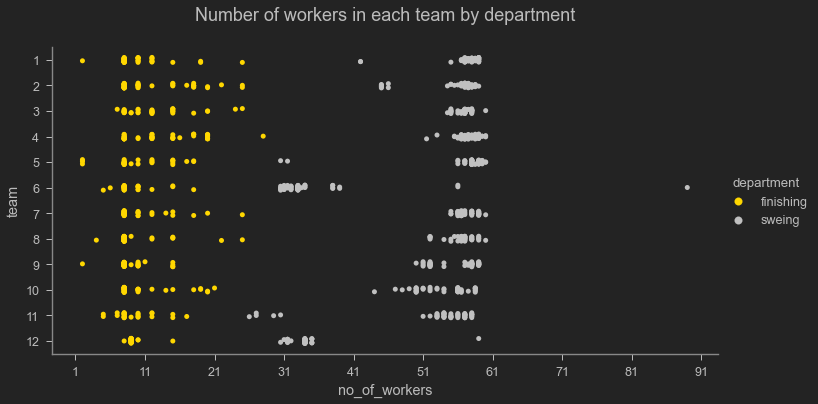

In [31]:
g = sns.catplot(data=df_eda,
                y='team',
                x='no_of_workers',
                hue='department',
                palette=cust_pal2, aspect=2)
plt.xticks(ticks=np.arange(1, 95, 10), rotation=0)
# g.set(yticks=df_eda.team.cat.categories)
plt.title(f'Number of workers in each team by department\n',size=18,weight=4)
plt.show()

Generally finishing department worker size is low.

##### efficient team

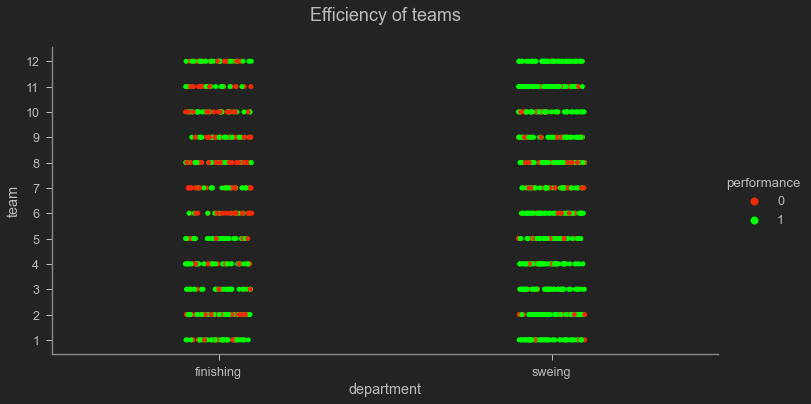

In [32]:
g = sns.catplot(data=df_eda,
                y='team',
                x='department',
                hue='performance',
                palette=cust_pal,
                aspect=2)
g.set(yticks=df_eda.team.unique())
plt.title(f'Efficiency of teams\n', size=18, weight=4)

plt.show()

Finishing department fails to achieve goal more often. 

#### `smv` on `performance`

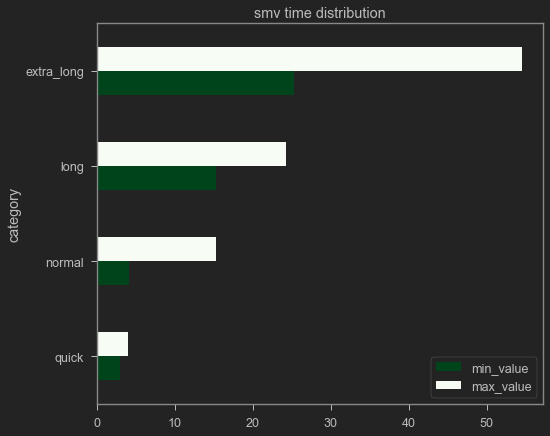

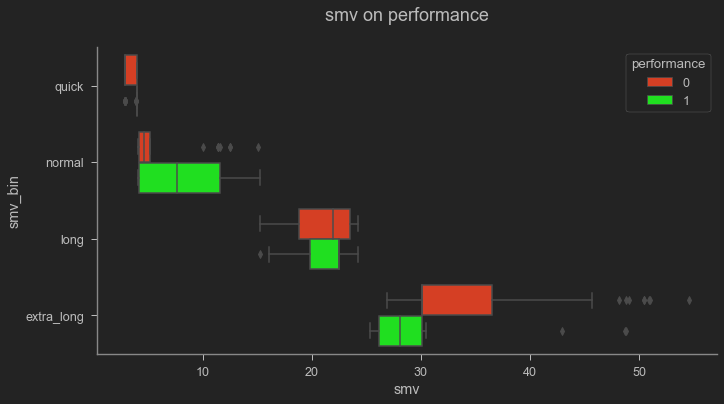

In [33]:
# empty list to hold data
lst = []
# preparing data of smv_bin distribution
for i in zip(df_eda.smv_bin.cat.categories,
             df_eda.groupby('smv_bin')['smv'].agg('min'),
             df_eda.groupby('smv_bin')['smv'].agg('max')):
    temp_dict = {'category': i[0], 'min_value': i[1], 'max_value': i[2]}
    lst.append(temp_dict)
# plotting
pd.DataFrame(lst).set_index('category').plot.barh(
    colormap='Greens_r', title='smv time distribution')
sns.catplot(y="smv_bin",
            x='smv',
            kind="box",
            hue="performance",
            data=df_eda,
            aspect=2,
            palette=cust_pal,
            legend_out=False)
plt.title(f'smv on performance\n', size=18, weight=4)
plt.show()

#### `wip` on `performance`

,min_value,max_value
category,,
no_wip,0,0
small,7,148
med,154,486
large,507,2120
xl,2698,23122


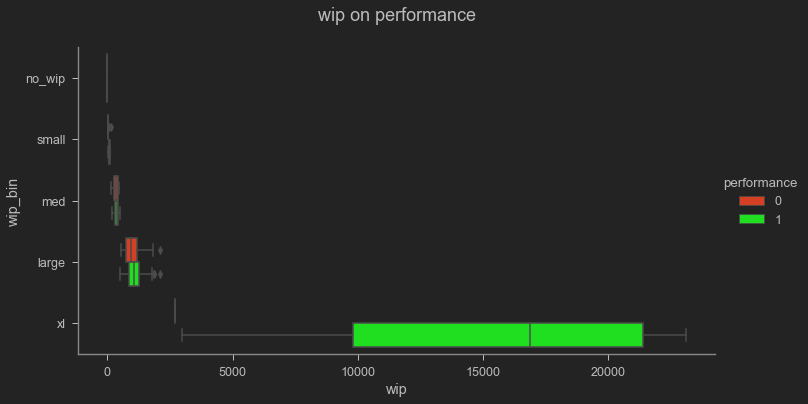

In [34]:
# empty list to hold data
lst = []
# preparing data of wip_bin distribution
for i in zip(df_eda.wip_bin.cat.categories,
             df_eda.groupby('wip_bin')['wip'].agg('min'),
             df_eda.groupby('wip_bin')['wip'].agg('max')):
    temp_dict = {'category': i[0], 'min_value': i[1], 'max_value': i[2]}
    lst.append(temp_dict)
display(
    pd.DataFrame(lst).set_index('category').style.format(
        "{:.0f}").set_properties(**{'color': 'lawngreen'}))
sns.catplot(y="wip_bin",
            x='wip',
            kind="box",
            hue="performance",
            data=df_eda,
            aspect=2,
            palette=cust_pal)
plt.title(f'wip on performance\n', size=18, weight=4)
plt.show()

At higher wip there is less chance of failing.

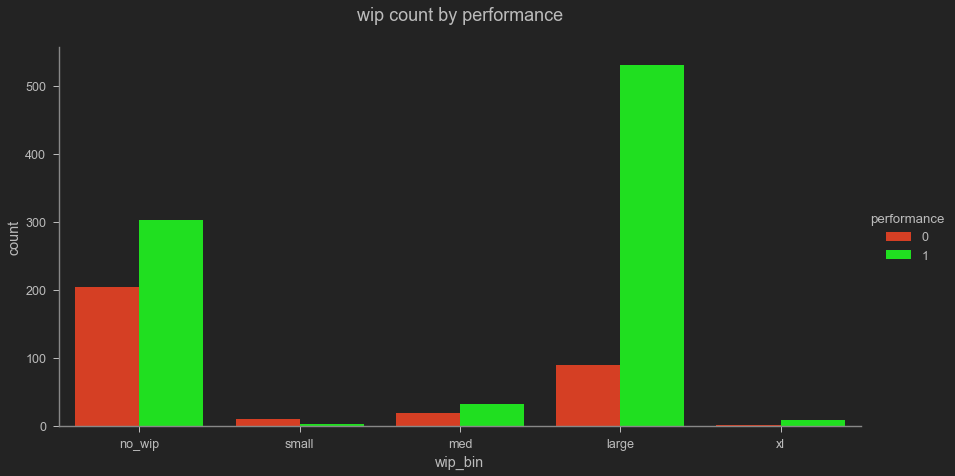

In [35]:
sns.catplot(x="wip_bin",
            kind="count",
            hue="performance",
            data=df_eda,
            aspect=2,
            height=6,
            palette=cust_pal)
plt.title(f'wip count by performance\n', size=18, weight=4)
plt.show()

Same pattern, low wip does not necessarily mean a good workday. Some leftover work for the next day can mean that there is a greater chance of meeting that days goal.

#### `incentive` on `performance`

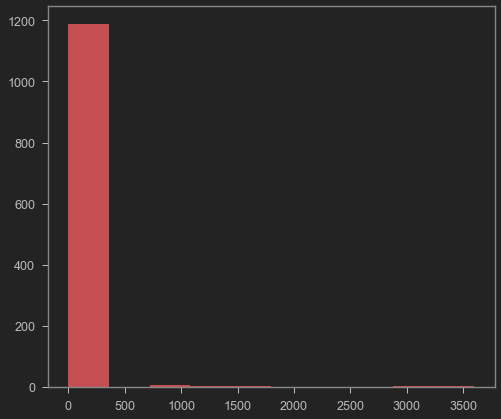

In [36]:
df_eda['incentive'].hist(color='r',grid=False);

`incentive` distribution is highly skewed. lets slice by 500 BDT.

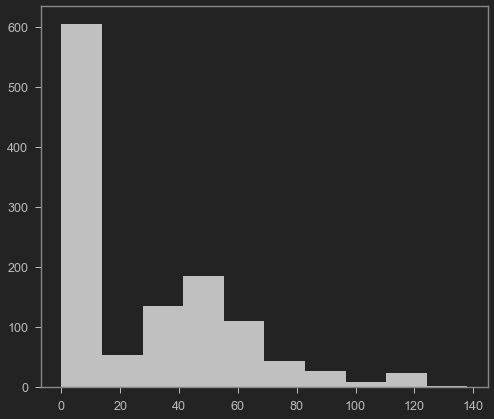

In [37]:
df_eda[df_eda['incentive']<500]['incentive'].hist(color='silver',grid=False);

Most of the day there is no incentive payment.

In [38]:
print(
    f"""`incentive` and `performance` have a {df_eda[df_eda['incentive']<500]
.corr()['incentive']['performance'].round(4)} correlaiton"""
)

`incentive` and `performance` have a 0.4001 correlaiton


A word of caution, high correlation does not necessarily mean causation.

,min_value,max_value
category,,
no_incentive,0,29
minor,30,75
med,81,138
large,960,1440
generous,2880,3600


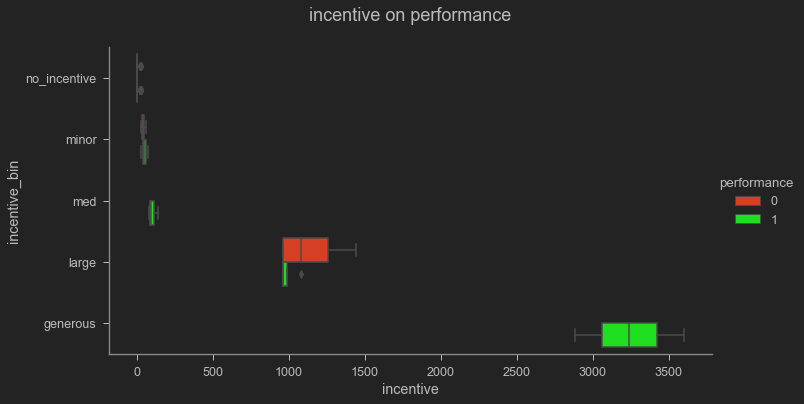

In [39]:
# empty list to hold data
lst = []
# preparing data of incentive_bin distribution
for i in zip(df_eda.incentive_bin.cat.categories,
             df_eda.groupby('incentive_bin')['incentive'].agg('min'),
             df_eda.groupby('incentive_bin')['incentive'].agg('max')):
    temp_dict = {'category': i[0], 'min_value': i[1], 'max_value': i[2]}
    lst.append(temp_dict)
display(
    pd.DataFrame(lst).set_index('category').style.format(
        "{:.0f}").set_properties(**{'color': 'lawngreen'}))
sns.catplot(y="incentive_bin",
            x='incentive',
            kind="box",
            hue="performance",
            data=df_eda,
            aspect=2,
            palette=cust_pal)
plt.title(f'incentive on performance\n', size=18, weight=4)
plt.show()

After binning it can be seen that at higher incentive the performance is better, as no goal unmet at generous incentive.

### preparing data for model

In [40]:
print(f"""numeric cols: {df.select_dtypes('number').columns.tolist()}
categorical cols: {df.select_dtypes('category').columns.tolist()}""")

numeric cols: ['targeted_productivity', 'smv', 'wip', 'over_time', 'incentive', 'idle_time', 'idle_men', 'no_of_style_change', 'no_of_workers', 'performance']
categorical cols: ['quarter', 'department', 'day', 'team']


#### split using `sklearn`

I am using train-test split approach here. Other option is to use train-validation-test data split approach. As the data set is relatively small, the later approach makes my train data have fewer samples to train on. This is a real issue for model performance for some of the models used. They perform better with more train data.

In [41]:
X = df.drop(columns='performance').copy()
y = df['performance'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25)

In [42]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((897, 13), (897,), (300, 13), (300,))

In [43]:
print(f"""Class balance y_train: 
{y_train.value_counts(1)}
""")
print(f"""Class balance y_test: 
{y_test.value_counts(1)}
""")

Class balance y_train: 
1    0.729097
0    0.270903
Name: performance, dtype: float64

Class balance y_test: 
1    0.736667
0    0.263333
Name: performance, dtype: float64



Distribution of target class is somewhat consistent. Can be re-run for different distribution. But this is not necessary as I am tackling class imbalance issue with `SMOTENC`.

#### Addressing class imbalance using `SMOTENC`

In [44]:
# keeping a class imbalanced dataset set for evaluation of preocess
X_imba, y_imba = X.copy(), y.copy()
X_imba.shape, y_imba.shape

((1197, 13), (1197,))

In [45]:
# creating a copy just to be safe.
XX = X.copy()
yy = y.copy()

# first four features are categorical;
# in the original paper (Rahim, 2021) attached to this dataset also 
# considered `team` as categorical feature.
smotenc_features=[True]*4+[False]*9
# initialize SMOTENC
oversampling = SMOTENC(categorical_features=smotenc_features,n_jobs=-1)
# fiting
XX_oversampled, yy_oversampled = oversampling.fit_sample(XX,yy)
# updating dataset
X_train, y_train = XX_oversampled.copy(), yy_oversampled.copy()
X_train.shape, y_train.shape

((1750, 13), (1750,))

#### OHE using `pandas`

In [46]:
# as a reference point for pipelining process validation
pd.get_dummies(X_train).shape, pd.get_dummies(X_test).shape

((1750, 33), (300, 33))

#### Pipelining

In [47]:
# testing pipeline. for each model I shall use slightly diffrent pipeline.
_test_pipe_train, _test_pipe_test = fun.dataset_preprocessing_pipeline(
    X_train, X_test, scaler=fun.RobustScaler(), drop='first')
display(_test_pipe_train.describe().T.round(2),
        _test_pipe_test.describe().T.round(2))

,count,mean,std,min,25%,50%,75%,max
targeted_productivity,1750.0,-0.20,0.89,-4.00,-0.50,0.0,0.50,0.50
smv,1750.0,0.14,0.59,-0.44,-0.38,0.0,0.62,2.22
wip,1750.0,0.44,1.29,-0.13,-0.13,0.0,0.87,22.88
over_time,1750.0,0.15,0.59,-0.60,-0.38,0.0,0.62,4.04
incentive,1750.0,0.76,3.57,0.00,0.00,0.0,1.00,90.00
idle_time,1750.0,0.98,14.79,0.00,0.00,0.0,0.00,300.00
idle_men,1750.0,0.57,3.66,0.00,0.00,0.0,0.00,45.00
no_of_style_change,1750.0,0.13,0.39,0.00,0.00,0.0,0.00,2.00
no_of_workers,1750.0,0.01,0.46,-0.59,-0.47,0.0,0.53,1.18
quarter_Quarter2,1750.0,0.27,0.45,0.00,0.00,0.0,1.00,1.00


,count,mean,std,min,25%,50%,75%,max
targeted_productivity,300.0,-0.27,0.96,-4.00,-0.50,0.00,0.50,0.50
smv,300.0,0.20,0.56,-0.44,-0.38,0.20,0.62,2.03
wip,300.0,0.59,1.62,-0.13,-0.13,0.52,0.96,21.16
over_time,300.0,0.26,0.61,-0.60,-0.34,0.14,0.65,2.11
incentive,300.0,1.07,5.43,0.00,0.00,0.57,1.25,90.00
idle_time,300.0,0.55,8.67,0.00,0.00,0.00,0.00,150.00
idle_men,300.0,0.27,2.40,0.00,0.00,0.00,0.00,30.00
no_of_style_change,300.0,0.15,0.43,0.00,0.00,0.00,0.00,2.00
no_of_workers,300.0,0.09,0.44,-0.59,-0.43,0.06,0.53,0.59
quarter_Quarter2,300.0,0.28,0.45,0.00,0.00,0.00,1.00,1.00


pipeline is working!

# MODEL

## dummy model

Class balance y_train: 
1    0.5
0    0.5
Name: performance, dtype: float64

Class balance y_test: 
1    0.736667
0    0.263333
Name: performance, dtype: float64

------------------------------


******************************************************************************************
Train accuracy score: 0.4931
Test accuracy score: 0.5
    No over or underfitting detected, diffrence of scores did not cross 5% thresh hold.
******************************************************************************************

************************************************************
Classification report on train data of:
        DummyClassifier(strategy='stratified')
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.52      0.53      0.52       875
           1       0.52      0.52      0.52       875

    accuracy                           0.52      1750
   macro avg       0.52      0.52      0.52      1750
weighted avg       0.52      0.52      0.52      1750

************************************************************


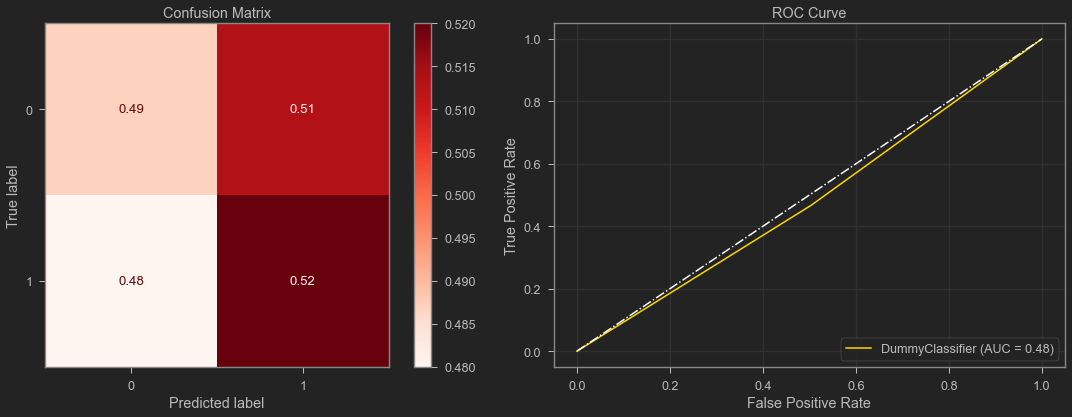

************************************************************
Classification report on test data of:
    DummyClassifier(strategy='stratified')
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.28      0.48      0.36        79
           1       0.75      0.56      0.64       221

    accuracy                           0.54       300
   macro avg       0.52      0.52      0.50       300
weighted avg       0.63      0.54      0.57       300

************************************************************


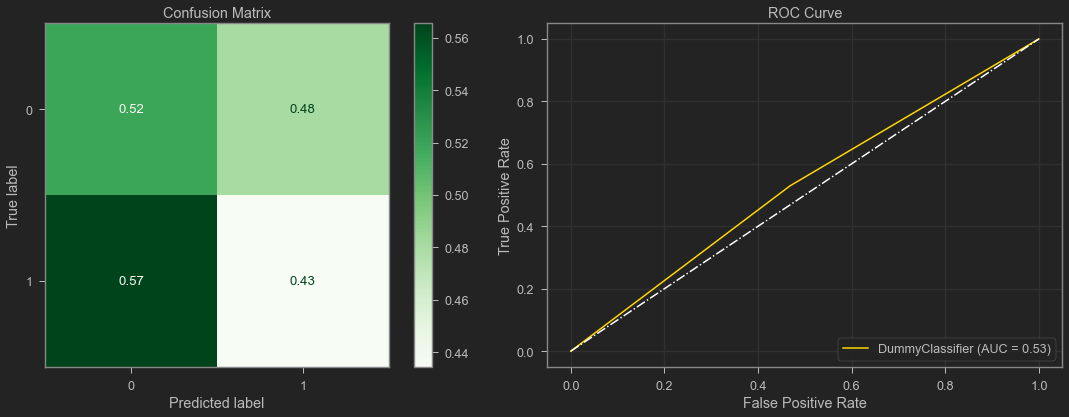

In [48]:
# SMOTENC'ed, StandardScaled and OHE'ed data
X_train_dummy, X_test_dummy = fun.dataset_preprocessing_pipeline(
    X_train, X_test)

dummy_classifier = DummyClassifier(strategy='stratified')
print(f"""Class balance y_train: 
{y_train.value_counts(1)}
""")
print(f"""Class balance y_test: 
{y_test.value_counts(1)}
""")
print(f"""{'-'*30}""")
fun.model_report(dummy_classifier,
                 X_train=X_train_dummy,
                 y_train=y_train,
                 X_test=X_test_dummy,
                 y_test=y_test,
                 cmap=['Reds', 'Greens'],
                 show_train_report=True)

This is a worthless model. The f1 score is low, model accuracy is .5. This is not even better than flipping a coin to predict, which should be correct at random. 

NOTE: there is no random seed for anything. For later run the sample drawn from train-test split can have a different subset, thus making most of my model evaluation commentary invalid. This is true for all of my modeling process.

## logistic regression

### filter with Pearson corr

Text(0, 0.5, 'features')

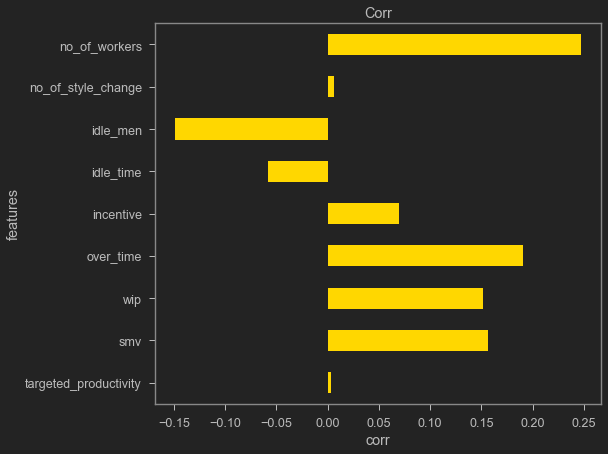

In [49]:
df.corr()['performance'][:-1].plot(kind='barh',color='gold')
plt.title('Corr')
plt.xlabel('corr')
plt.ylabel('features')

Most of them are correlated with the target except `no_of_style_change` and `targeted_productivity`.

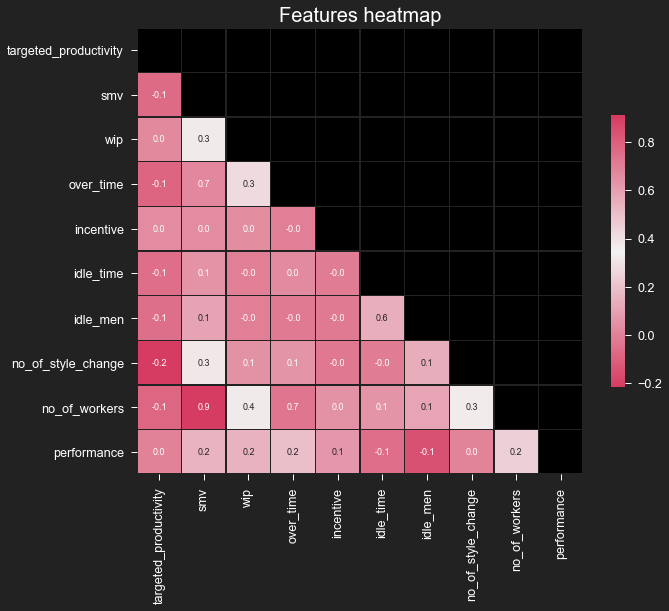

In [49]:
fun.heatmap_of_features(df);

* No significant correlation is detected except `no_of_worker` and `smv`.
* `overtime` and `no_of_worker` is correlated.

In [50]:
display(fun.top_correlated_features(df))
print(f"""Features should be dropped: {
                                    fun.drop_features_based_on_correlation(
                                    df, threshold=0.75)
                                        }""")

,feature_combo,correlation
0,smv and no_of_workers,0.912176


Features should be dropped: {'no_of_workers'}


In [51]:
# droping from train and test data
X_train_dropped_ = X_train.drop('no_of_workers',axis=1)
X_test_dropped_ = X_test.drop('no_of_workers',axis=1)
# SMOTENC'ed, StandardScaled, correlated feature dropped and OHE'ed data
X_train_log_reg, X_test_log_reg = fun.dataset_preprocessing_pipeline(
    X_train_dropped_, X_test_dropped_, drop='first')

### logistic regression classifier

******************************************************************************************
Train accuracy score: 0.7194
Test accuracy score: 0.7367
    No over or underfitting detected, diffrence of scores did not cross 5% thresh hold.
******************************************************************************************

************************************************************
Classification report on train data of:
        LogisticRegression(C=100000.0, class_weight='balanced', max_iter=1000)
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.71      0.74      0.72       875
           1       0.73      0.70      0.71       875

    accuracy                           0.72      1750
   macro avg       0.72      0.72      0.72      1750
weighted avg       0.72      0.72      0.72      1750

************************************************************


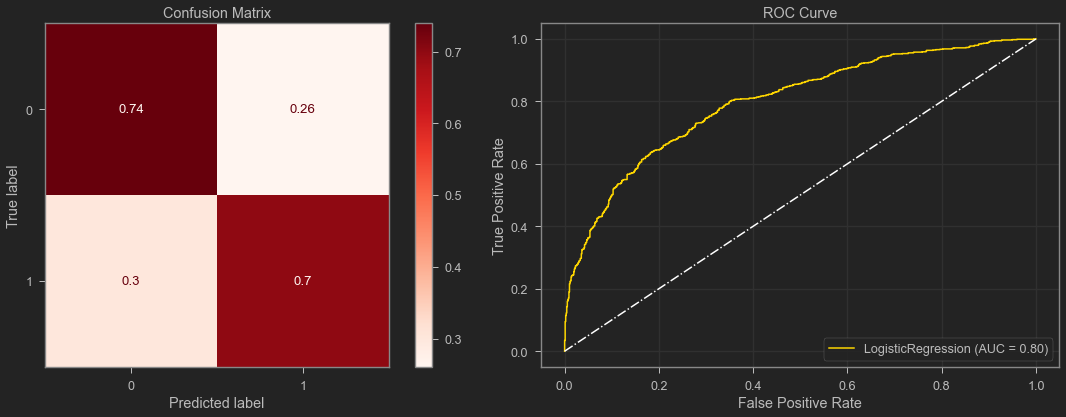

************************************************************
Classification report on test data of:
    LogisticRegression(C=100000.0, class_weight='balanced', max_iter=1000)
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.52      0.79      0.63        84
           1       0.90      0.72      0.80       216

    accuracy                           0.74       300
   macro avg       0.71      0.75      0.71       300
weighted avg       0.79      0.74      0.75       300

************************************************************


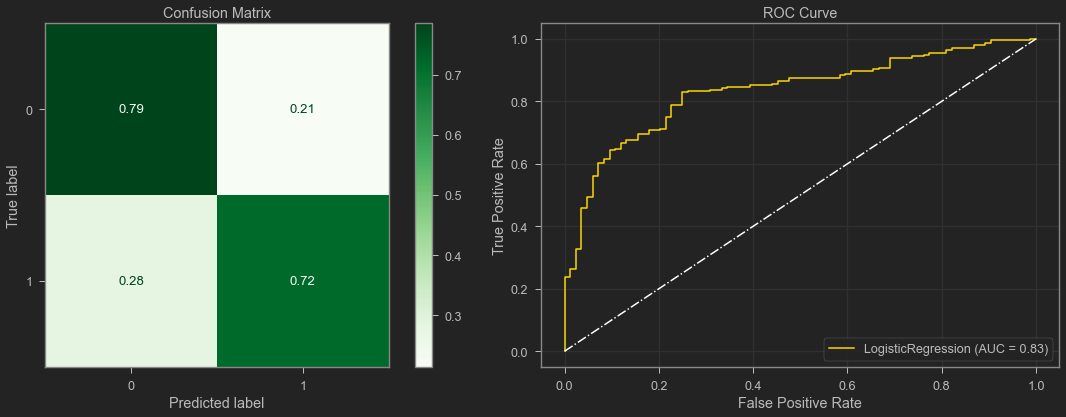

In [52]:
# logistic regression classifier
logreg = LogisticRegression(C=1e5, max_iter=1000, class_weight='balanced')
# score of logistic regression classifier
fun.model_report(logreg,
             X_train=X_train_log_reg,
             y_train=y_train,
             X_test=X_test_log_reg,
             y_test=y_test,show_train_report=True)

Overall good performance. Can detect majority of true negatives and positives, with good recall and and f1. ROC curve also looks good.

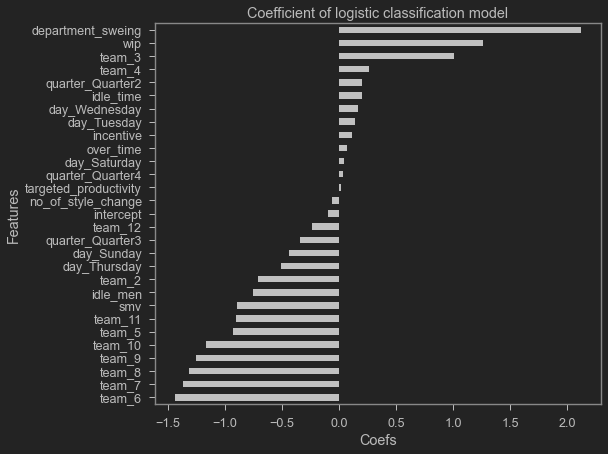

In [53]:
fun.coefficients_of_model_binary(
    logreg, X_train_log_reg, log_scale=True).sort_values().plot(kind='barh',
                                                                color='silver')
plt.title('Coefficient of logistic classification model')
plt.xlabel('Coefs')
plt.ylabel('Features');

By looking at the coefs of the model, I can have a idea of feature importance and their impact on the prediction. `department_sweing` and `wip` has highest coef. and some teams are under performing, but teams of both department share number as identifier.  

### grid search with Cross Validation

In [54]:
logreg_gs = LogisticRegression(max_iter=1e4,
                               class_weight='balanced',
                               n_jobs=-1)
params = {
    'C': [.1, 1, 10, 100, 10000, 1e6, 1e12],
    'tol': [0.0001, 0.001, 0.01, .1],
    'penalty': ['l1', 'l2', 'elasticnet', None],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}
gridsearch_logreg = GridSearchCV(estimator=logreg_gs,
                                 param_grid=params,
                                 n_jobs=-1,
                                 scoring='precision')
gridsearch_logreg

GridSearchCV(estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=10000.0, n_jobs=-1),
             n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100, 10000, 1000000.0,
                               1000000000000.0],
                         'penalty': ['l1', 'l2', 'elasticnet', None],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga'],
                         'tol': [0.0001, 0.001, 0.01, 0.1]},
             scoring='precision')

In [55]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    gridsearch_logreg.fit(X_train_log_reg, y_train)
print(f"Best Parameters by gridsearch:\t{gridsearch_logreg.best_params_}")
print(f"Best Estimator by gridsearch:\t{gridsearch_logreg.best_estimator_}")

Best Parameters by gridsearch:	{'C': 0.1, 'penalty': 'l1', 'solver': 'saga', 'tol': 0.0001}
Best Estimator by gridsearch:	LogisticRegression(C=0.1, class_weight='balanced', max_iter=10000.0, n_jobs=-1,
                   penalty='l1', solver='saga')


******************************************************************************************
Train accuracy score: 0.728
Test accuracy score: 0.7467
    No over or underfitting detected, diffrence of scores did not cross 5% thresh hold.
******************************************************************************************

************************************************************
Classification report on test data of:
    LogisticRegression(C=0.1, class_weight='balanced', max_iter=10000.0, n_jobs=-1,
                   penalty='l1', solver='saga')
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.53      0.80      0.64        84
           1       0.90      0.73      0.81       216

    accuracy                           0.75       300
   macro avg       0.72      0.76      0.72       300
weighted avg       0.80      0.75      0.76       300

*****************************************************

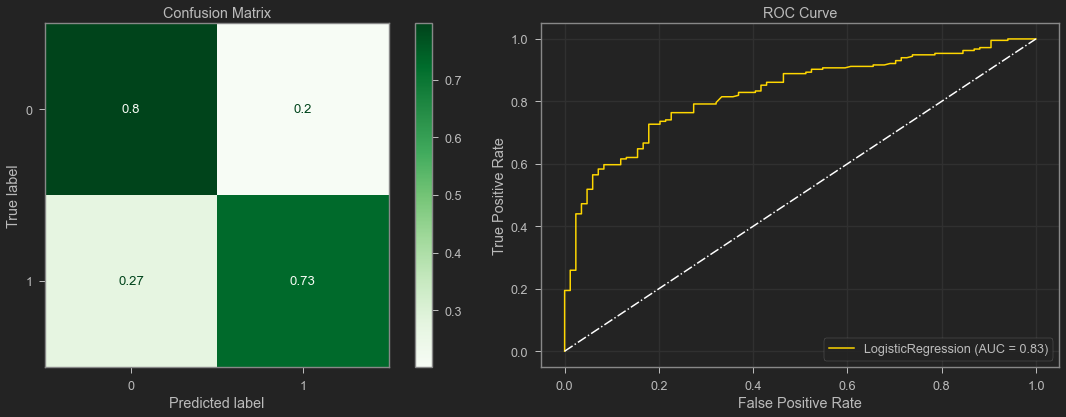

In [56]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    logreg_gs_best = gridsearch_logreg.best_estimator_
    fun.model_report(logreg_gs_best, X_train_log_reg, y_train, X_test_log_reg,
                 y_test)

Very minimal improvement overall.

At this point I can tackle outliers by removing them based on Z-score or IQR or other method; and considering scaling options can be done here. But chance of data loss is higher. Moreover, disruption of distribution of data is required for this process. <br>Moving on to next type of model. 

## KNN Clustering

******************************************************************************************
Train accuracy score: 0.8766
Test accuracy score: 0.8633
    No over or underfitting detected, diffrence of scores did not cross 5% thresh hold.
******************************************************************************************

************************************************************
Classification report on train data of:
        KNeighborsClassifier()
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       875
           1       0.90      0.85      0.87       875

    accuracy                           0.88      1750
   macro avg       0.88      0.88      0.88      1750
weighted avg       0.88      0.88      0.88      1750

************************************************************


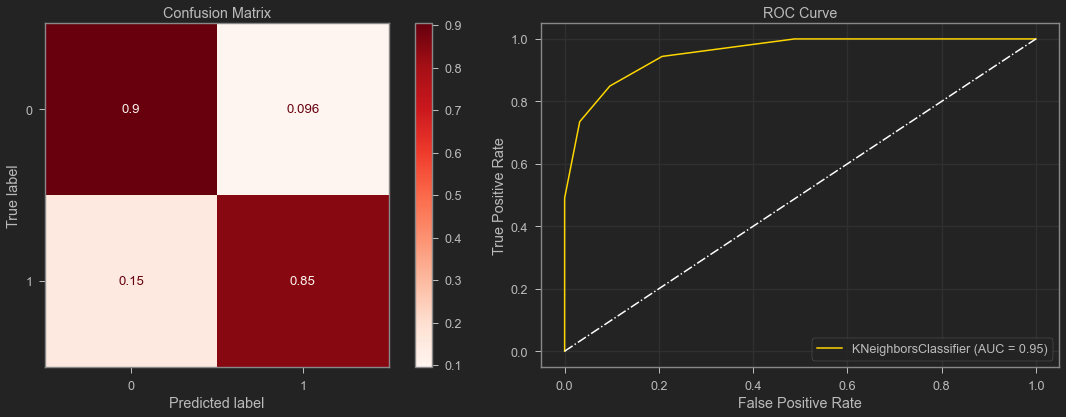

************************************************************
Classification report on test data of:
    KNeighborsClassifier()
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.72      0.85      0.78        84
           1       0.94      0.87      0.90       216

    accuracy                           0.86       300
   macro avg       0.83      0.86      0.84       300
weighted avg       0.87      0.86      0.87       300

************************************************************


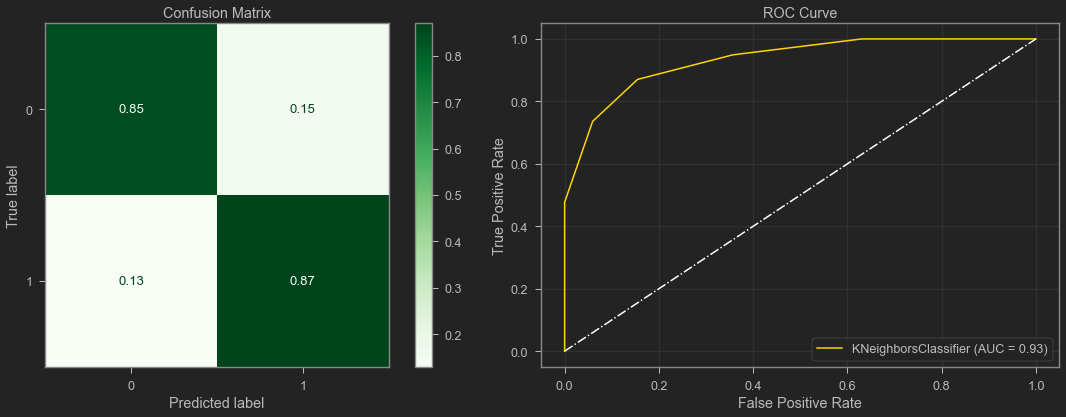

In [57]:
X_train_knn, X_test_knn = fun.dataset_preprocessing_pipeline(X_train, X_test)

knn = KNeighborsClassifier()
fun.model_report(knn,
                 X_train_knn,
                 y_train,
                 X_test_knn,
                 y_test,
                 show_train_report=True)

Way better performance than previous model. True negative and positives are better, all the metrics are looking good. ROC curve is improved. But this can be better better by some hyperparameter tuning.

### grid search with Cross Validation

In [58]:
knn_gs = KNeighborsClassifier(n_jobs=-1)
params = {
    'n_neighbors': list(range(1, 31, 2)),
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2, 2.5, 3, 4],
    'leaf_size': [30, 40],
    #     'metric': ['minkowski', 'manhattan', 'euclidean']
}
gridsearch_knn = GridSearchCV(estimator=knn_gs,
                              param_grid=params,
                              n_jobs=-1,
                              scoring='precision',return_train_score=True)
gridsearch_knn

GridSearchCV(estimator=KNeighborsClassifier(n_jobs=-1), n_jobs=-1,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'leaf_size': [30, 40],
                         'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21,
                                         23, 25, 27, 29],
                         'p': [1, 2, 2.5, 3, 4],
                         'weights': ['uniform', 'distance']},
             return_train_score=True, scoring='precision')

Best Parameters by gridsearch:	{'algorithm': 'auto', 'leaf_size': 30, 'n_neighbors': 17, 'p': 1, 'weights': 'distance'}
Best Estimator by gridsearch:	KNeighborsClassifier(n_jobs=-1, n_neighbors=17, p=1, weights='distance')


******************************************************************************************
Train accuracy score: 0.9994
Test accuracy score: 1.0
    No over or underfitting detected, diffrence of scores did not cross 5% thresh hold.
******************************************************************************************

************************************************************
Classification report on test data of:
    KNeighborsClassifier(n_jobs=-1, n_neighbors=17, p=1, weights='distance')
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        84
           1       1.00      1.00      1.00       216

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300

************************************************************


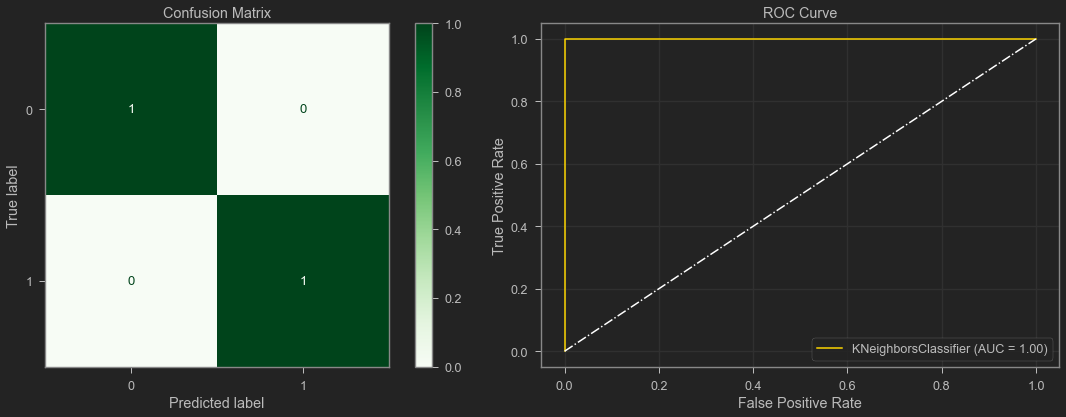

In [59]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    gridsearch_knn.fit(X_train_knn, y_train)
print(f"Best Parameters by gridsearch:\t{gridsearch_knn.best_params_}")
print(f"Best Estimator by gridsearch:\t{gridsearch_knn.best_estimator_}")

knn_gs_best = gridsearch_knn.best_estimator_
fun.model_report(knn_gs_best, X_train_knn, y_train, X_test_knn,
             y_test)

Perfect result. It can predict with certainty. It has all the scores perfect across all the metrics and ROC curve is perfect.

In [60]:
knn_gs_best.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': -1,
 'n_neighbors': 17,
 'p': 1,
 'weights': 'distance'}

These are the best parameters.

In [61]:
pd.DataFrame(
    gridsearch_knn.cv_results_).sort_values(by='rank_test_score')[:10].T

,81,681,1131,231,831,981,381,531,1121,971
mean_fit_time,0.0498116,0.0252148,0.00700092,0.0240042,0.0598116,0.0249104,0.032206,0.0197113,0.00640202,0.0202043
std_fit_time,0.0332004,0.0135042,0.00464852,0.00982071,0.0535227,0.0383508,0.0411872,0.020915,0.00338312,0.0324251
mean_score_time,0.266023,0.321938,0.274399,0.109526,0.223077,0.331765,0.3191,0.39962,0.132533,0.276663
std_score_time,0.0821157,0.0914245,0.135999,0.0116336,0.11702,0.13501,0.0970569,0.226828,0.0595649,0.140997
param_algorithm,auto,kd_tree,brute,auto,kd_tree,brute,ball_tree,ball_tree,brute,brute
param_leaf_size,30,30,40,40,40,30,30,40,40,30
param_n_neighbors,17,17,17,17,17,17,17,17,15,15
param_p,1,1,1,1,1,1,1,1,1,1
param_weights,distance,distance,distance,distance,distance,distance,distance,distance,distance,distance
params,"{'algorithm': 'auto', 'leaf_size': 30, 'n_neig...","{'algorithm': 'kd_tree', 'leaf_size': 30, 'n_n...","{'algorithm': 'brute', 'leaf_size': 40, 'n_nei...","{'algorithm': 'auto', 'leaf_size': 40, 'n_neig...","{'algorithm': 'kd_tree', 'leaf_size': 40, 'n_n...","{'algorithm': 'brute', 'leaf_size': 30, 'n_nei...","{'algorithm': 'ball_tree', 'leaf_size': 30, 'n...","{'algorithm': 'ball_tree', 'leaf_size': 40, 'n...","{'algorithm': 'brute', 'leaf_size': 40, 'n_nei...","{'algorithm': 'brute', 'leaf_size': 30, 'n_nei..."


Here is a sneak peek of all the models created by grid search. It found 8 perfect models.

## ensemble methods

In [54]:
X_train_ensbl, X_test_ensbl = fun.dataset_preprocessing_pipeline(
    X_train, X_test)

### Random Forest™


<br>`Random Forest` is a trademark of Leo Breiman and Adele Cutler and is licensed exclusively to "Salford Systems", subsidiary of "Minitab, LLC", for the commercial release of the software. Random Forest A.K.A. random decision forests. This is one of the extensively used black-box models. KKN and RF can be both classified as <i>weighted neighborhoods schemes</i>. I am using scikit-learn's implementation of the concept.



<br>RF generally requires less tuning for acceptable performance. Thus I am using random decision forest here, as I got a good result using KNN after some hyperparameter tuning via grid search with cross validation.

In [55]:
rf_clf = RandomForestClassifier()

******************************************************************************************
Train accuracy score: 0.9994
Test accuracy score: 0.9967
    No over or underfitting detected, diffrence of scores did not cross 5% thresh hold.
******************************************************************************************

************************************************************
Classification report on test data of:
    RandomForestClassifier()
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        79
           1       1.00      1.00      1.00       221

    accuracy                           1.00       300
   macro avg       0.99      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300

************************************************************


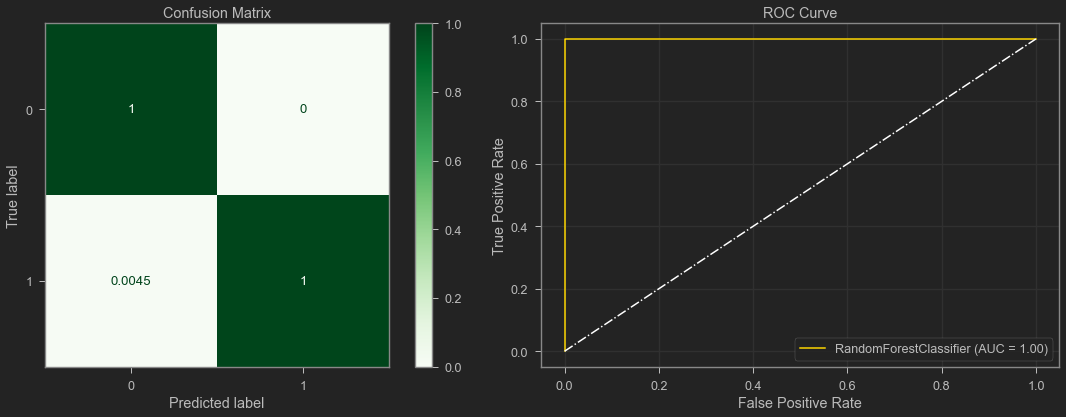

In [56]:
fun.model_report(rf_clf, X_train_ensbl, y_train, X_test_ensbl,
             y_test)

As expected I have the same level of performance with the out-of-the-box model without any tuning. Lets look at the first few nods of the tree of the 10th tree. I choose 10th at random. This output is not friendly to see in a notebook. A copy of this can be found at `'./saved_model/rf_clf_sample_4.pdf'` in side this repository as a pdf file.

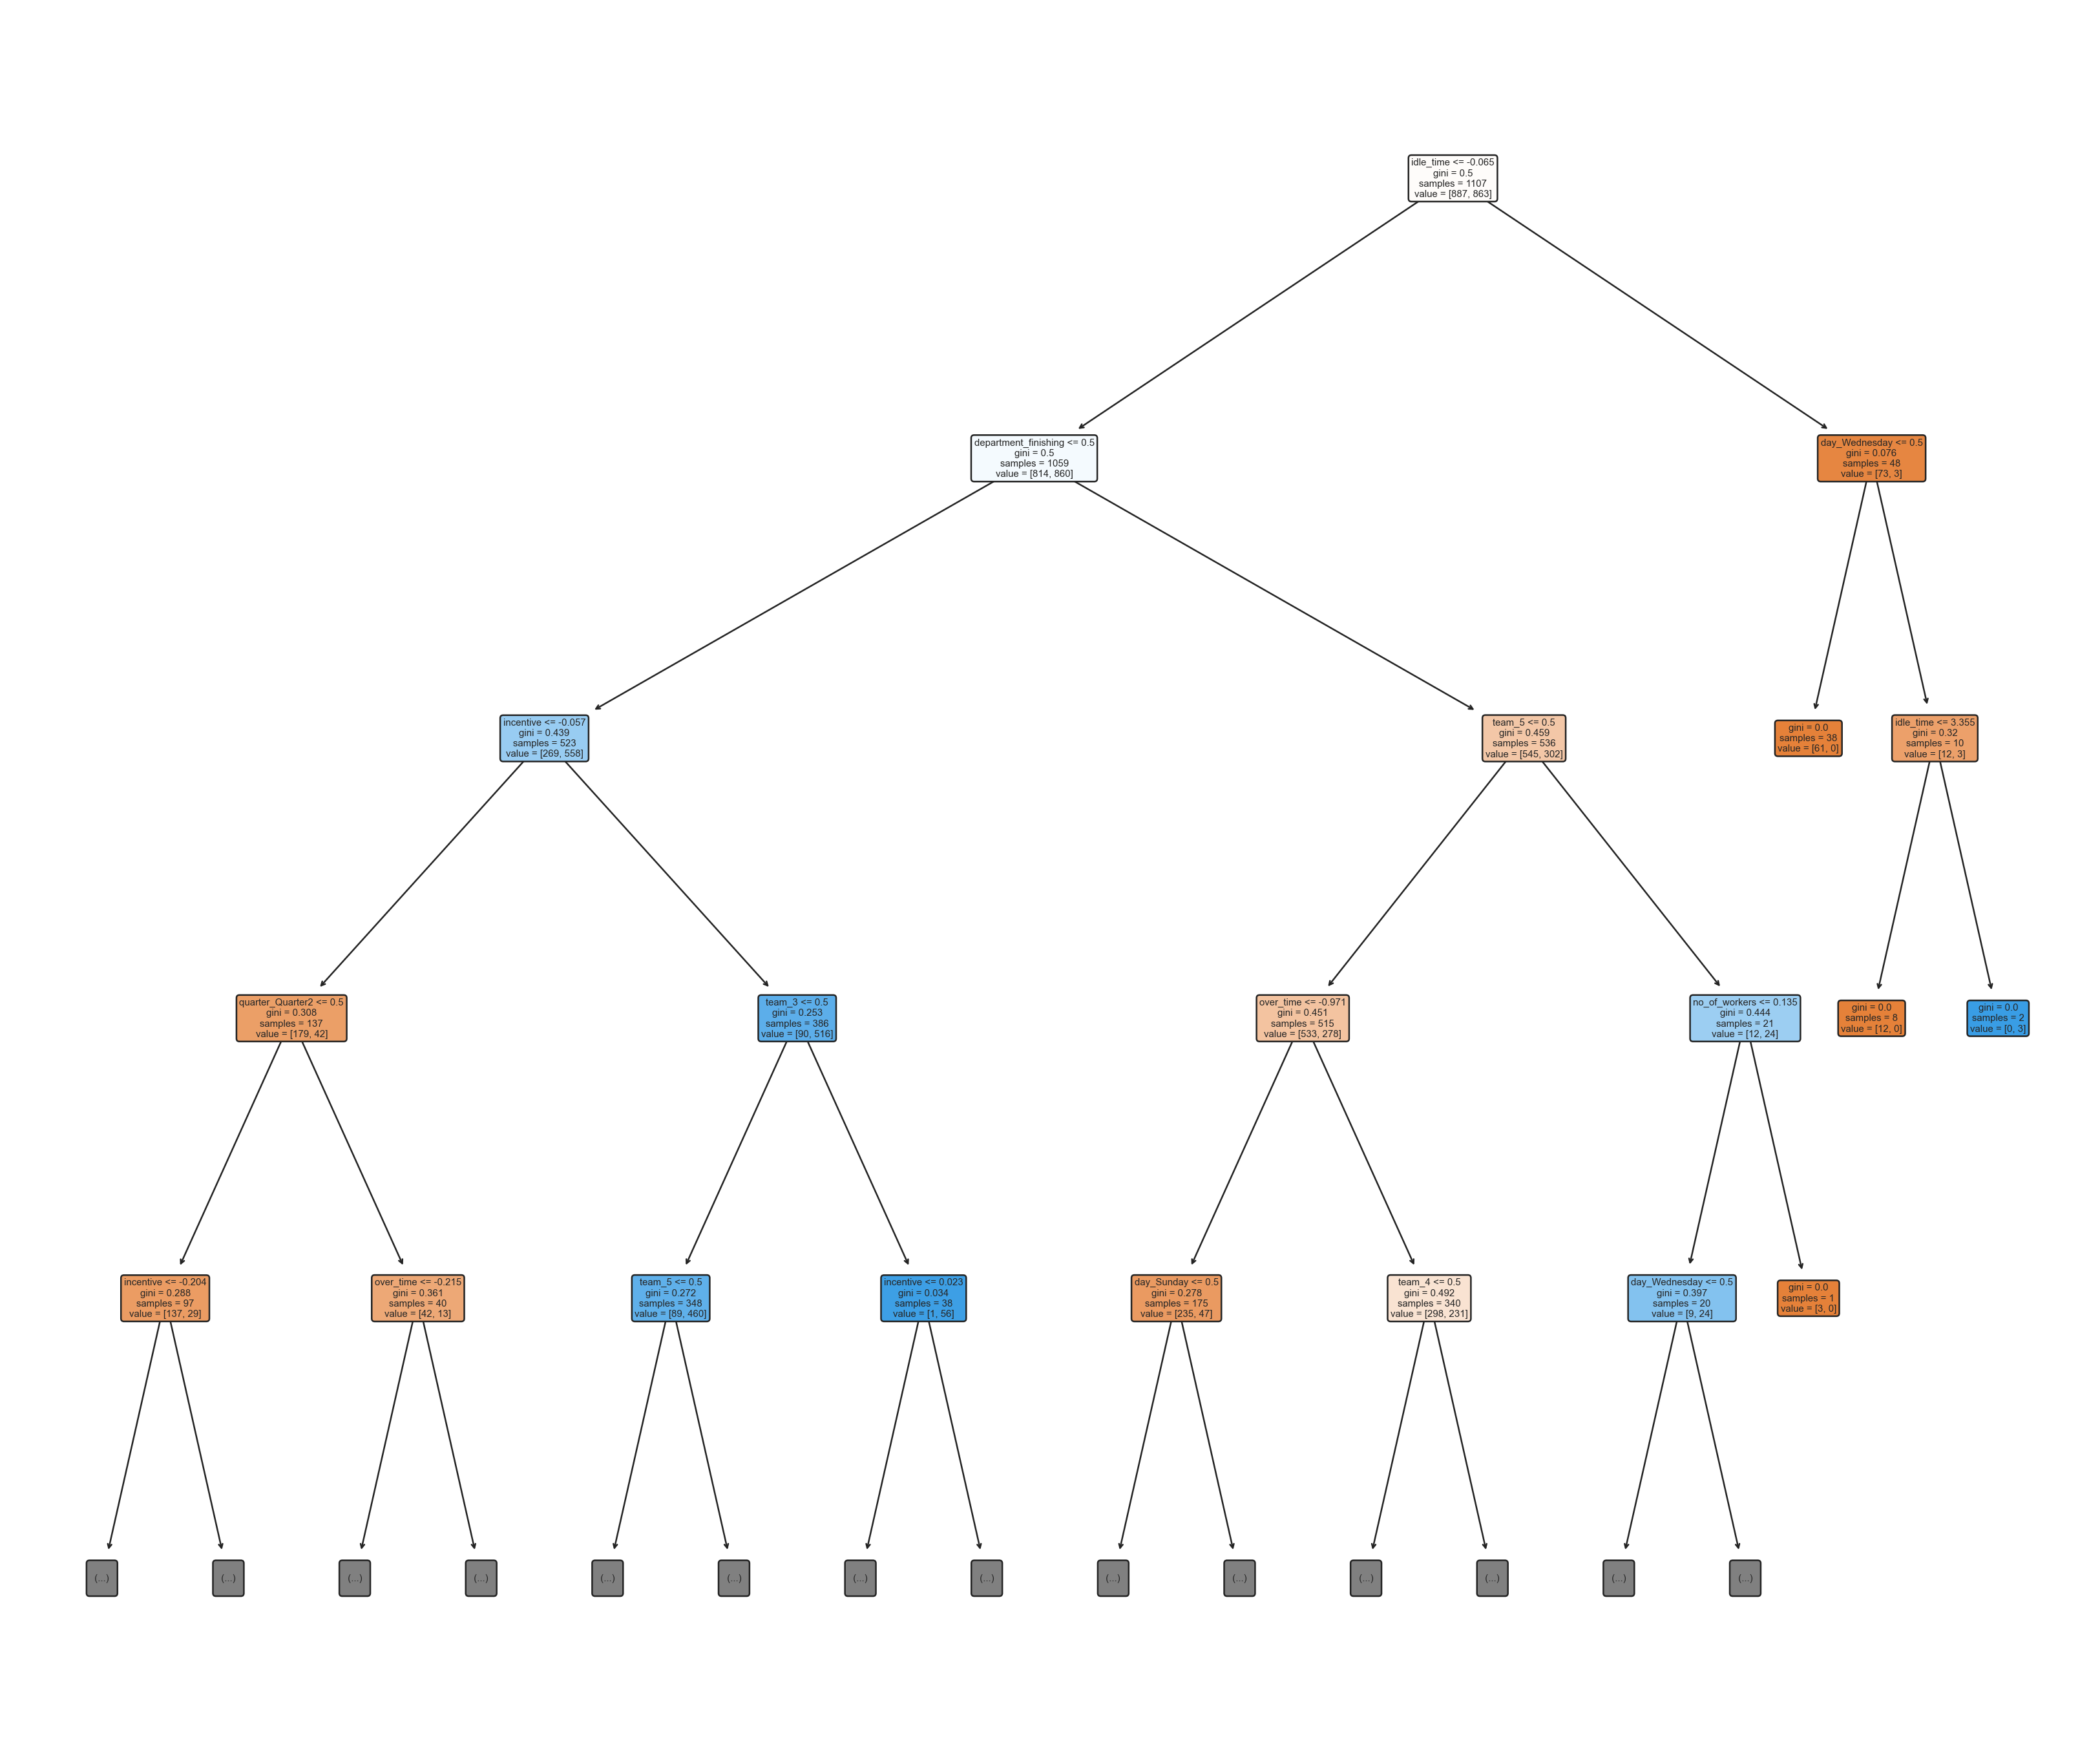

In [65]:
with plt.style.context('seaborn'):
    fig, ax = plt.subplots(figsize=(6, 5), dpi=600)
    fig.tight_layout()
    tree.plot_tree(rf_clf.estimators_[10],
                   feature_names=X_train_ensbl.columns,
                   max_depth=4,
                   filled=True,
                   rounded=True)
    fig.savefig('./saved_model/rf_clf_sample_4.pdf',
                dpi=300,
                orientation='landscape',
                facecolor='white')

Parameter used for the model:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


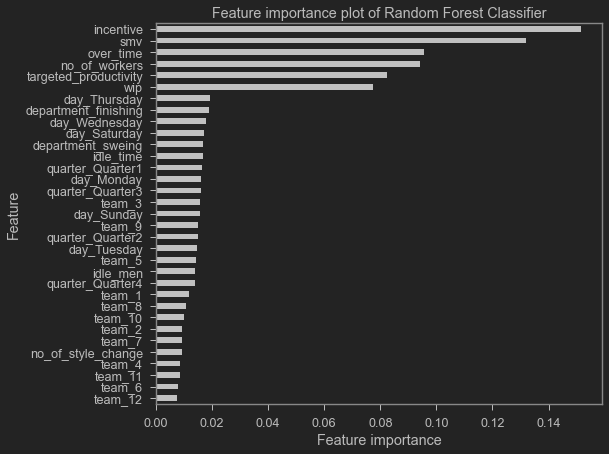

In [66]:
# used parameters for the classifier
print("Parameter used for the model:")
print(rf_clf.get_params())
# feature importance
pd.DataFrame(rf_clf.feature_importances_,
             index=X_test_ensbl.columns).sort_values(by=0).plot(kind='barh',
                                                                legend='',
                                                                color='silver')
plt.title('Feature importance plot of Random Forest Classifier')
plt.ylabel('Feature')
plt.xlabel('Feature importance');

Most important features are, in descending order, `incentive`, `smv`, `overtime`, `no_of_workers`, `targeted_productivity` and so on. 
This means those features were often used for building the forests. And those features make real life sense also.

## Selecting Best model

Random Forest model is the best one, this can achieve perfect prediction with minimal effort. 
<br>This is `rf_clf` model object in this notebook.

# INTERPRET

In [58]:
# init shap
shap.initjs()

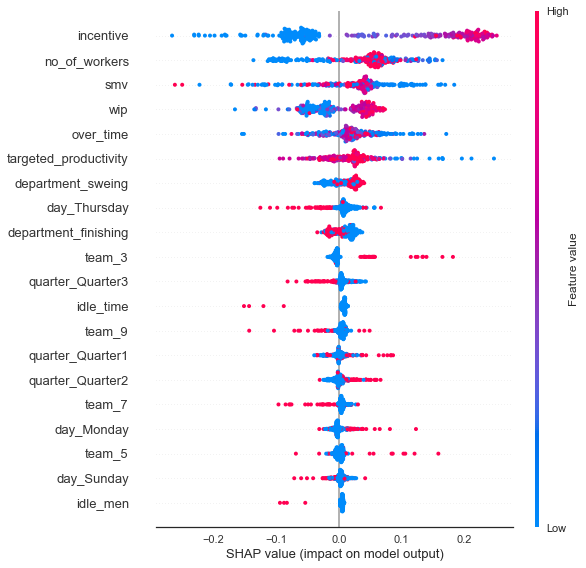

In [76]:
# explain all the predictions in the test set
explainer = shap.TreeExplainer(rf_clf)
shap_values = explainer.shap_values(X_test_ensbl)
with plt.style.context('seaborn-white'):
    shap.summary_plot(shap_values[1], X_test_ensbl)

This plot is showing contribution of each feature on a machine learning model prediction. This graph is for detecting goal met class.
- Few explanations:
<br>

    | Features | Probability of goal met | Probability of goal not met |
    |-|-|-|
    | department_finishing | Lower Value | Higher Value |
    | department_sweing | High Value | Lower Value |
    | idle_men | Lower Value |  |
    | idle_time | Lower Value |  |
    | incentive | High Value | Lower Value |
    | no_of_workers | Above Average | Below Average And High |
    | over_time | Average | Below Average And High |
    | smv | Above Average | Below Average And High |
    | targeted_productivity | Lower Value | Higher Value |
    | wip | High Value | Lower Value |


Here weights explained in tabular form 

In [127]:
eli5.format_as_dataframe(eli5.explain_weights(
    rf_clf, feature_names=list(X_test_ensbl.columns)))

,feature,weight,std
0,incentive,0.158867,0.068949
1,smv,0.124824,0.040667
2,no_of_workers,0.109437,0.040290
3,over_time,0.102029,0.025587
4,targeted_productivity,0.099527,0.027682
5,team,0.098398,0.020972
6,wip,0.079831,0.051646
7,quarter_Quarter1,0.018690,0.006853
8,department_finishing,0.017462,0.029487
9,department_sweing,0.017232,0.030081


In [62]:
fun.javascript_formatter(shap.force_plot(explainer.expected_value[0], 
                                         shap_values[0],
                                         feature_names=X_test_ensbl.columns).
                                         _repr_html_())

This interactive plot has all the instances and their impact on the final model.

Peeking into one of the citizens of the random forest voters. I picked this at random using a random number generator.

In [52]:
# x = np.random.randint(100)
x

In [162]:
eli5.explain_prediction(
    rf_clf, X_test_ensbl.iloc[x], feature_names=list(X_test_ensbl.columns))

Explanation(estimator='RandomForestClassifier()', description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble (or a single tree for DecisionTreeClassifier).\nEach node of the tree has an output score, and contribution of a feature\non the decision path is how much the score changes from parent to child.\nWeights of all features sum to the output score or proba of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does not show how increasing or\n   decreasing the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision path', is_regression=False, targets=[TargetExplanation(target=0, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='<BIAS>', weight=0.5003314285714288, std=None, value=1.0), FeatureWeight(feature='smv', weight=0.07076519085527301, std=None, value=-0.8577537234005602), FeatureWeight(feature='incentive', weight=0.06011705649214153, std=None, value=-0.2189406314710275), FeatureWeight(feature='quarter_Quarter1', weight=0.0483561045227838, std=None, value=1.0), FeatureWeight(feature='day_Monday', weight=0.0435149643326248, std=None, value=0.0), FeatureWeight(feature='quarter_Quarter4', weight=0.041273857748578016, std=None, value=0.0), FeatureWeight(feature='day_Tuesday', weight=0.03849542581057023, std=None, value=1.0), FeatureWeight(feature='wip', weight=0.038463571076397744, std=None, value=-0.4418515571470569), FeatureWeight(feature='quarter_Quarter2', weight=0.02821981430124622, std=None, value=0.0), FeatureWeight(feature='day_Sunday', weight=0.025274536036780954, std=None, value=0.0), FeatureWeight(feature='department_finishing', weight=0.0111738669209691, std=None, value=1.0), FeatureWeight(feature='department_sweing', weight=0.010145044419543132, std=None, value=0.0), FeatureWeight(feature='quarter_Quarter5', weight=0.00364026860903804, std=None, value=0.0), FeatureWeight(feature='no_of_style_change', weight=0.0003035217769745219, std=None, value=-0.3271940724868952)], neg=[FeatureWeight(feature='team', weight=-0.09614332301151607, std=None, value=-0.8014936519070163), FeatureWeight(feature='targeted_productivity', weight=-0.03282142213768466, std=None, value=0.7741878270877041), FeatureWeight(feature='day_Thursday', weight=-0.023811271305801594, std=None, value=0.0), FeatureWeight(feature='quarter_Quarter3', weight=-0.021701270617635115, std=None, value=0.0), FeatureWeight(feature='no_of_workers', weight=-0.02105683638554456, std=None, value=-0.8734547046551392), FeatureWeight(feature='day_Wednesday', weight=-0.013705187414853113, std=None, value=0.0), FeatureWeight(feature='day_Saturday', weight=-0.003624187656538897, std=None, value=0.0), FeatureWeight(feature='idle_men', weight=-0.0030624971115985273, std=None, value=-0.1644966842882116), FeatureWeight(feature='idle_time', weight=-0.002418086486213879, std=None, value=-0.06540067580079735), FeatureWeight(feature='over_time', weight=-0.0017305693469633321, std=None, value=-0.84378326060226)], pos_remaining=0, neg_remaining=0), proba=0.7, score=None, weighted_spans=None, heatmap=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None, image=None)

## saving model

In [66]:
# fun.save_model(rf_clf,custom_prefix='ta')

File saved: ta_RandomForestClassifier_5_22_2021_19_2_31.joblib


In [67]:
lod_mod = joblib.load(
    './saved_model/ta_RandomForestClassifier_5_22_2021_19_2_31.joblib')
lod_mod

# RECOMMENDATION & CONCLUSION

This model can be used with confidence for predicting employee performance. It can detect both True negatives and positives with high precision.

- Few insights where to focus
    - `incentive` is very important decider for performance.
    - tune optimal `no_of_workers` for better performance.
    

# NEXT STEPS

- do a multi-class prediction by further binning of target.
- fit a model with entire data and prepare for production use.
- fine-tune functions for general use and add options for users.
- mend appendix contents

# APPENDIX

## all functions and imports from the `functions.py` and `packages.py`

In [148]:
fun.show_py_file_content('./imports_and_functions/functions.py')

```python
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, RobustScaler, QuantileTransformer, PowerTransformer, MaxAbsScaler, Normalizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from IPython.display import display, HTML, Markdown
from sklearn import metrics
from imblearn.over_sampling import SMOTE, SMOTENC
import joblib 
import time
### function name starting with "z_" are experimental and not fully tested ###
# Future plan: restructure functions to behave as attached to class using OOP#
# handle multinomial target plotting, use modin in place of pandas

def its_alive(str_='Hellow World!! I am Alive!!!'):
    """testing import"""
    print(str_)
    
def check_NaN(df):
    """
    Checks for NaN in the pandas DataFrame and spits a DataFrame of report.
    Uses df.isnull() method.
    
    Parameters:
    ===========
    df = pandas.DataFrame
    
    Returns:
    ========
    pandas.DataFrame

    ---version 0.9---
    """
    null_checking = []
    for column in df.columns:
        not_null = df[column].isnull().value_counts()[0]
        try:
            is_null = df[column].isnull().value_counts()[1]
        except:
            is_null = 0
        temp_dict = {'name': column, 'is_null': is_null, 'not_null': not_null}
        null_checking.append(temp_dict)
    df_ = pd.DataFrame(null_checking)
    return df_


def check_duplicates(df, verbose=False, limit_output=True, limit_num=150):
    """
    Checks for duplicates in the pandas DataFrame and return a Dataframe of report.
    
    Parameters:
    ===========
    df = pandas.DataFrame
    verbose = `int` or `boolean`; default: `False`
                `True` returns DataFrame with details of features.
                `False` returns DataFrame without details of features.
    limit_output = `int` or `boolean`; default: `True`
                `True` limits featurs display to 150.
                `False` details of unique features.
    limit_num = `int`, limit number of uniques; default: 150,

    Returns:
    ========
    pandas.DataFrame

    ---version 1.2---
    """
    dup_checking = []
    for column in df.columns:
        not_duplicated = df[column].duplicated().value_counts()[0]
        try:
            duplicated = df[column].duplicated().value_counts()[1]
        except:
            duplicated = 0
        temp_dict = {
            'name': column,
            'duplicated': duplicated,
            'not_duplicated': not_duplicated
        }
        dup_checking.append(temp_dict)
    df_ = pd.DataFrame(dup_checking)

    if verbose:
        if limit_output:
            for col in df:
                if (len(df[col].unique()))<=limit_num:
                    print(f"{col} >> number of uniques: {len(df[col].unique())}\n{df[col].unique()}")
                else:
                    print(f"{col} >> number of uniques: {len(df[col].unique())}, showing top {limit_num} values\n{df[col].unique()[:limit_num]}")
                print(f"{'_'*60}")
        else:
            for col in df:
                print(f"{col} >> number of uniques: {len(df[col].unique())}\n{df[col].unique()}")
    return df_


def num_col_for_plotting(row, col=3):
    """
    +++ formatting helper function +++
    __________________________________
    Returns number of rows to plot
    
    Parameters:
    ===========
    row = int;
    col = int; default col: 3

    Return:
    =======
    `int` == row // col
    """
    if row % col != 0:
        return (row // col) + 1
    else:
        return row // col


def distribution_of_features(df, n_cols=3, fig_size=(16, 26), color_plot='gold', kde_show=True, label_rotation=45, set_loglevel='warning'):
    """
    Plots distribution of features in a pandas.DataFrame.
    Does not work on feature encoded as category.

    Parameters:
    ===========
    df          = pandas.DataFrame,
    n_cols      = int; default: 3,
                    controls number of columns per row of the figure.
    fig_size    = tuple (length, height); default: (16, 26),
                    controls the figure size of the output. 
    color_plot  = str; default: 'gold',
                    controls color of the histplot and kde plot.
    kde_show    = `int` or `boolean`; default: `True`,
                    `True` shows kde plot.
                    `False` does not show kde plot.
    label_rotation = int; default: 45,
                    sets x label rotation.
    set_loglevel = str; default: 'warning',
                    The log level of matplotlib warning handler.
                    - options = {"notset", "debug", "info", "warning", "error", "critical"}
                    
    
    ---version 1.2---
    """
    plt.set_loglevel(set_loglevel)

    fig, axes = plt.subplots(nrows=num_col_for_plotting(len(df.columns),
                                                        col=n_cols),
                             ncols=n_cols,
                             figsize=fig_size,
                             sharey=False)
    for ax, column in zip(axes.flatten(), df):
        sns.histplot(x=column, data=df, color=color_plot, ax=ax, kde=kde_show)
        ax.set_title(f'Histplot of {column.title()}')
        ax.tick_params('x', labelrotation=label_rotation)
        sns.despine()
        plt.tight_layout()
        plt.suptitle('Histogram plots of the dataset',
                     fontsize=20,
                     fontweight=3,
                     va='bottom')
    plt.show()
        


def dataset_preprocessing_pipeline(X_train, X_test, scaler=StandardScaler(), drop=None):
    """
    Takes X_train, and X_test DataFrames. Then seperates DataFrame by categorical and numerical coulmns, and performs OneHotEncoding with droping control on categorical coulumns and scaling on numerical columns, user can select scalers. 
    Returns transformed DataFrames.
    
    All transforming steps are done using scikit-learn preprocessing, pipeline, and compose objects; and DataFrame creation is done with pandas. 
    
    Parameters:
    ===========
    X_train = pandas.DataFrame object; no default,
                training split of the DataFrame.
    X_test  = pandas.DataFrame object; no default,
                testing split of the DataFrame.
    scaler  = `sklarn scaler object` or `None`; default: StandardScaler(),
                *** IMPORT desired scaler before using. ***
                *** OR call with this module. all of them are imported and ready 
                to use inside this module.***
                Available options:
                - StandardScaler: removes the mean and scales the data to 
                    unit variance. 
                - MinMaxScaler: rescales the data set such that all feature 
                    values are in the range [0, 1]
                - RobustScaler: is based on percentiles and are therefore not
                    influenced by a few number of very large marginal outliers.
                - QuantileTransformer: applies a non-linear transformation 
                    such that the probability density function of each feature
                    will be mapped to a uniform or Gaussian distribution.
                - PowerTransformer: applies a power transformation to each 
                    feature to make the data more Gaussian-like in order to 
                    stabilize variance and minimize skewness.
                - MaxAbsScaler: is similar to `MinMaxScaler` except that the
                    values are mapped in the range [0, 1]
                - Normalizer: rescales the vector for each sample to have 
                    unit norm, independently of the distribution of the samples.
                - None: does not scale data.
    drop    = str or `None`; default: None.
                Option to control OneHotEncoder droping.
                - None : retain all features (the default).
                - 'first' : drop the first category in each feature. If only one
                  category is present, the feature will be dropped entirely.
                - 'if_binary' : drop the first category in each feature with two
                  categories. Features with 1 or more than 2 categories are
                  left intact.
                - array : ``drop[i]`` is the category in feature ``X[:, i]`` that
                  should be dropped.
    Return:
    =======
    X_train = modified pandas.DataFrame
    X_test  = modified pandas.DataFrame
    
    NOTE: 
        - possible error if test data has unseen category; creating new 
          DataFrame will fail.
        - Source can be modified to add more preprocessing steps.
    
    Next steps: 
    - add oversampling
    - return pipeline

    ---version 0.9.9---
    """
    # isolating numerical features
    nume_cols = X_train.select_dtypes('number').columns.to_list()
    # isolating categorical features
    cate_cols = X_train.select_dtypes('category').columns.to_list()
    
    # pipeline for processing categorical features
    pipe_cate = Pipeline([('ohe', OneHotEncoder(sparse=False, drop=drop))])
    # pipeline for processing numerical features
    pipe_nume = Pipeline([('scaler', scaler)])
    
    # Coulmn transformer
    preprocessor = ColumnTransformer([
        ('numerical_features', pipe_nume, nume_cols),
        ('categorical_features', pipe_cate, cate_cols)
    ])
    
    ## creating a pandas.DataFrame with appropriate column name
    # creating modified X_train
    ret_X_train = pd.DataFrame(
        preprocessor.fit_transform(X_train),
        columns=nume_cols +
        preprocessor.named_transformers_['categorical_features'].
        named_steps['ohe'].get_feature_names(cate_cols).tolist())
    
    # creating modified X_test
    # NOTE: possible error if test data has unseen category, in this step.
    # for debugging such error modify this and its processing.
    ret_X_test = pd.DataFrame(
        preprocessor.transform(X_test),
        columns=nume_cols +
        preprocessor.named_transformers_['categorical_features'].
        named_steps['ohe'].get_feature_names(cate_cols).tolist())
    return ret_X_train, ret_X_test

def coefficients_of_model_binary(model,X_train_data, log_scale=True):
    """
    Returns a pandas.Series object with intercept and coeffients of a logistic regression model with features as index.
    
    Parameters:
    ===========
    model        = object; No Default. 
                    fitted sklearn model object with a coef_ and intercept_ attribute.
    X_train_data = pandas.DataFrame; No Default.
                    DataFrame of independant variables. Should be train-test splitted. 
                    Use train data.  
    log_scale    = boolean; default: True.
                    `True` for keeping log scale of coefficients.
                    `False` for converting to normal scale.

    """
    coeffs = pd.Series(model.coef_.flatten(), index=X_train_data.columns)
    coeffs['intercept'] = model.intercept_[0]
    if log_scale is False:
        coeffs = np.exp(coeffs)
    return coeffs

def coefficients_of_model(model, log_scale=True):
    """
    Returns a pandas.Series object with intercept and coeffients.
    
    Parameters:
    ===========
    model        = object; No Default. 
                    fitted sklearn model object with a coef_ and intercept_ attribute.
    log_scale    = boolean; default: True.
                    `True` for keeping log scale of coefficients.
                    `False` for converting to normal scale.
    
    """
    coeffs = pd.Series(model.coef_.flatten())
    coeffs['intercept'] = model.intercept_[0]
    if log_scale is False:
        coeffs = np.exp(coeffs)
    return coeffs

def save_model(model, location='',custom_prefix=''):
    """
    Saves object locally as binary format with and as joblib.
    Adds local machine time to name to the file for easy recongnition.

    Parameters:
    ===========
    model = object to save,
    location = str; default: '',
            File save location. If empty, i.e., "", saves at root.
    custom_prefix = str; default: '',
            Adds prefix to file
    
    Future plan: 
    - modify naming options
   
    --version 0.0.1--
    
    """
    def str_model_(model):
        """Helper function to get model class display statement, this text 
        conversion breaks code if performed in ``save_model`` function's 
        local space. This function is to isolate from the previous function's 
        local space."""
        str_model = str(model.__class__).split('.')[-1][:-2]
        return str_model

    # get model name
    name = str_model_(model)
    # save time
    month = str(time.localtime().tm_mon)
    day = str(time.localtime().tm_mday)
    year = str(time.localtime().tm_year)
    hour = str(time.localtime().tm_hour)
    min_ = str(time.localtime().tm_min)
    sec = str(time.localtime().tm_sec)
    save_time = '_'.join([month, day, year, hour, min_, sec])

    file_name_ = '_'.join([custom_prefix, name, save_time])
    save_path = location+file_name_+'.joblib'
    joblib.dump(model, save_path)
    print(f'File saved: {save_path}')

def heatmap_of_features(df, annot_format='.1f'):
    """
    Return a masked heatmap of the given DataFrame
    
    Parameters:
    ===========
    df            = pandas.DataFrame object.
    annot_format  = str, for formatting; default: '.1f'
    
    Example of `annot_format`:
    --------------------------
    .1e = scientific notation with 1 decimal point (standard form)
    .2f = 2 decimal places
    .3g = 3 significant figures
    .4% = percentage with 4 decimal places
    
    Note:
    =====
    Rounding error can happen if '.1f' is used.
    
    -- version: 1.1 --
    """
    with plt.style.context('dark_background'):
        plt.figure(figsize=(10, 10), facecolor='k')
        mask = np.triu(np.ones_like(df.corr(), dtype=bool))
        cmap = sns.diverging_palette(3, 3, as_cmap=True)
        ax = sns.heatmap(df.corr(),
                    mask=mask,
                    cmap=cmap,
                    annot=True,
                    fmt=annot_format,
                    linecolor='k',
                    annot_kws={"size": 9},
                    square=True,
                    linewidths=.5,
                    cbar_kws={"shrink": .5})
        plt.title(f'Features heatmap', fontdict={"size": 20})
        plt.show()
        return ax
    
def top_correlated_features(df, limit=.75, verbose=False):
    """
    Input a Pandas DataFrame to get top correlated (based on absolute value) features filtered by a cutoff.
    
    Parameters:
    ===========
    df        = pandas.DataFrame object.
    limit     = float; default: .75
    verbose   = boolean; default: False. 
                `True` returns DataFrame without filtering by cutoff.
                `False` returns DataFrame filted by cutoff.
    """
    df_corr = df.corr().abs().unstack().reset_index().sort_values(
        0, ascending=False)
    df_corr.columns = ["feature_0", 'feature_1', 'correlation']
    df_corr['keep_me'] = df_corr.apply(
        lambda x: False if x['feature_0'] == x['feature_1'] else True, axis=1)
    df_corr['feature_combo'] = df_corr.apply(
        lambda x: ' and '.join(set(x[['feature_0', 'feature_1']])), axis=1)

    corr_features = df_corr[df_corr.keep_me == True][[
        'feature_combo', 'correlation'
    ]].drop_duplicates().reset_index(drop='index')
    # features with correlation more than 75%
    if verbose == True:
        return corr_features
    else:
        return corr_features[corr_features.correlation > limit]

def drop_features_based_on_correlation(df, threshold=0.75):
    """
    Returns features with high collinearity.
    
    Parameters:
    ===========
    df = pandas.DataFrame; no default.
            data to work on.
    threshold = float; default: .75.
            Cut off value of check of collinearity.
    
    -- ver: 1.0 --
    """
    # Set of all the names of correlated columns
    feature_corr = set()
    corr_matrix = df.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            # absolute coeff value
            if abs(corr_matrix.iloc[i, j]) > threshold:
                # getting the name of column
                colname = corr_matrix.columns[i]
                feature_corr.add(colname)
    return feature_corr

def show_py_file_content(file='./imports_and_functions/functions.py'):
    """
    displays content of a py file output formatted as python code in jupyter notebook.
    
    Parameter:
    ==========
    file = `str`; default: './imports_and_functions/functions.py',
                path to the py file.
    """
    with open(file, 'r') as f:
        x = f"""```python
{f.read()}
```"""
        display(Markdown(x))

def z_dataset_preprocessing_pipeline(X_train,
                                     X_test,
                                     y_train=None,
                                     scaler=StandardScaler(),
                                     drop=None,
                                     oversampling=True,
                                     return_pipeline_object=False):
    """ ######## Work in progress. Code works good enough.
    Takes X_train, and X_test DataFrames. Then seperates DataFrame by categorical and numerical coulmns, and performs OneHotEncoding with droping control on categorical coulumns and scaling on numerical columns, user can select scalers. 
    Returns transformed DataFrames.
    
    All transforming steps are done using scikit-learn preprocessing, pipeline, and compose objects; and DataFrame creation is done with pandas. 
    
    :::: MAKE SURE EVERY FEATURE HAS CORRECT DATA TYPE; EITHER CATEGORICAL OR NUMERICAL :::

    Parameters:
    ===========

    X_train = pandas.DataFrame object; no default,
                training split of the DataFrame.
    X_test  = pandas.DataFrame object; no default,
                testing split of the DataFrame.
    scaler  = `sklarn scaler object` or `None`; default: StandardScaler(),
                *** IMPORT desired scaler before using. ***
                *** OR call with this module. all of them are imported and ready 
                to use inside this module.***
                Available options:
                - StandardScaler: removes the mean and scales the data to 
                    unit variance. 
                - MinMaxScaler: rescales the data set such that all feature 
                    values are in the range [0, 1]
                - RobustScaler: is based on percentiles and are therefore not
                    influenced by a few number of very large marginal outliers.
                - QuantileTransformer: applies a non-linear transformation 
                    such that the probability density function of each feature
                    will be mapped to a uniform or Gaussian distribution.
                - PowerTransformer: applies a power transformation to each 
                    feature to make the data more Gaussian-like in order to 
                    stabilize variance and minimize skewness.
                - MaxAbsScaler: is similar to `MinMaxScaler` except that the
                    values are mapped in the range [0, 1]
                - Normalizer: rescales the vector for each sample to have 
                    unit norm, independently of the distribution of the samples.
                - None: does not scale data. #::: NOT TESTED :::#
    drop    = str or `None`; default: None.
                Option to control OneHotEncoder droping.
                - None : retain all features (the default).
                - 'first' : drop the first category in each feature. If only one
                  category is present, the feature will be dropped entirely.
                - 'if_binary' : drop the first category in each feature with two
                  categories. Features with 1 or more than 2 categories are
                  left intact.
                - array : ``drop[i]`` is the category in feature ``X[:, i]`` that
                  should be dropped.
    oversampling = boolean; default: True,
                    turn oversampling on or off; 
                - `True` oversamples.
                - `False` no oversampling.
    return_pipeline_object= boolean; default: False, {not sure how it might be useful though #::: NOT TESTED :::#}
                    control object return.
                - `True` returns object.
                - `False` does not return object.
    NOTE: 
        - possible error if test data has unseen category; creating new 
          DataFrame will fail.
        - Source can be modified to add more preprocessing steps.
    
    Stage: Coding

    Next steps: 
    - use OOP to make this a class. 
    - Add oversampling method changing option.
    - add imputer in the pipeline.
    - add and remove steps in pipeline option.

    ---version 0.0.1 beta---
    """
    # isolating numerical features
    nume_cols = X_train.select_dtypes('number').columns.to_list()
    # isolating categorical features
    cate_cols = X_train.select_dtypes('category').columns.to_list()

    # pipeline for processing categorical features
    pipe_cate = Pipeline([('ohe', OneHotEncoder(sparse=False, drop=drop))])
    # pipeline for processing numerical features
    pipe_nume = Pipeline([('scaler', scaler)])

    # Coulmn transformer
    preprocessor = ColumnTransformer([
        ('numerical_features', pipe_nume, nume_cols),
        ('categorical_features', pipe_cate, cate_cols)
    ])

    # creating a pandas.DataFrame with appropriate header
    # creating modified X_train
    ret_X_train = pd.DataFrame(
        preprocessor.fit_transform(X_train),
        columns=nume_cols +
        preprocessor.named_transformers_['categorical_features'].
        named_steps['ohe'].get_feature_names(cate_cols).tolist())

    # creating modified X_test
    ## NOTE: possible error if test data has unseen category, in this step.
    ## for debugging such error modify this, and its processing steps `in pipe_cate`.
    ret_X_test = pd.DataFrame(
        preprocessor.transform(X_test),
        columns=nume_cols +
        preprocessor.named_transformers_['categorical_features'].
        named_steps['ohe'].get_feature_names(cate_cols).tolist())
    
    # NEW ADDITION
    if oversampling:
        smotenc_features = [True] * len(nume_cols) + [False] * len(
            preprocessor.named_transformers_['categorical_features'].
            named_steps['ohe'].get_feature_names(cate_cols).tolist())
        oversampling_ = SMOTENC(categorical_features=smotenc_features,
                                n_jobs=-1)
        X_train_oversampled = oversampling_.fit_sample(ret_X_train, y_train)

    if return_pipeline_object:
        if oversampling:
            return preprocessor, X_train_oversampled, ret_X_test
        else:
            return preprocessor, ret_X_train, ret_X_test
    else:
        if oversampling:
            return X_train_oversampled, ret_X_test
        else:
            return ret_X_train, ret_X_test
    
def z_experimental_model_report_(model,
                                 X_train,
                                 y_train,
                                 X_test,
                                 y_test,
                                 cmap=['Reds', 'Greens'],
                                 normalize='true',
                                 figsize=(16, 6),
                                 show_train_report=False,
                                 show_train_roc=False,
                                 fitted_model=False,
                                 display_labels=['not_met', 'met']):
    """ ### Work in progress, code works. Bulding upon the working version of the code.###
    Report of model performance using train-test split dataset.
    Shows train and test score, Confusion Matrix and, ROC Curve of performane of test data.
    
    Intended to work ONLY on model where target has properly encoded binomial class value.
    
    Parameters:
    ===========
    model     = object, scikit-learn model object; no default.
    X_train   = pandas.DataFrame, predictor variable training data split; no default,
    y_train   = pandas.DataFrame, target variable training data split; no default,
    X_test    = pandas.DataFrame, predictor variable test data split; no default,
    y_test    = pandas.DataFrame, target variable test data split; no default,
    cmap      = str, colormap of Confusion Matrix; default: 'Greens',
    normalize = str, normalize count of Confusion Matrix; default: 'true',
                - `true` to normalize counts.
                - `false` to show raw scounts.
    figsize   = tuple ``(lenght, height)``, figsize of output; default: (16, 6),
    show_train_report= boolean; default: False,
                - True, to show report.
                - False, to turn off report.
    fitted_model = False,
    display_labels = ['not_met', 'met']
    
    Future plan:
    - `save model` option in local drive using joblib or pickle
    - return fitted model
    - diffrent scorer option for report
    - turn off testing model performance on test data 
    - bring fuctionality from the old model
    - rebuild for multiclass using yellowbricks
    - another version of code for reporting already fitted model #-code ready-#
    - return reusable report object
    - add labaling options for 0 and 1 target class in report ===> confusion matrix. #-code ready for two class- rethink implimentation#
    - rethink control flow of display options, am I using more code than necessary?

    Stage: Concept, idea generation.
    
    Changelog:
    - built skeleton
    - added fitted_model
    - added display_labels

    ---version 0.0.1 pre-alpha---
    """
    def str_model_(model):
        """Helper function to get model class display statement, this text conversion breaks code if 
        performed in ``model_report`` function's local space. This function is to isolate from the 
        previous function's local space. Can use class here"""
        str_model = str(model.__class__).split('.')[-1][:-2]
        display(
            HTML(
                f"""<strong>Report of {str_model} type model using train-test split dataset.</strong>"""
            ))

    str_model_(model)
    X_train = X_train.copy()
    y_train = y_train.copy()
    if fitted_model is False:
        model.fit(X_train, y_train)
    print(f"{'*'*90}")
    train = model.score(X_train, y_train)
    test = model.score(X_test, y_test)
    print(f"""Train accuracy score: {train.round(4)}""")
    print(f"""Test accuracy score: {test.round(4)}""")
    if abs(train - test) <= .05:
        print(
            f"    No over or underfitting detected, diffrence of scores did not cross 5% thresh hold."
        )
    elif (train - test) > .05:
        print(
            f"    Possible Overfitting, diffrence of scores {round(abs(train-test)*100,2)}% crossed 5% thresh hold."
        )
    elif (train - test) < -.05:
        print(
            f"    Possible Underfitting, diffrence of scores {round(abs(train-test)*100,2)}% crossed 5% thresh hold."
        )
    print(f"{'*'*90}")
    print("")
    print(f"{'*'*60}")

    if (show_train_roc) & (show_train_report):
        print(f"""Classification report on train data of:
        {model}""")
        print(f"{'-'*60}")
        print(metrics.classification_report(y_train, model.predict(X_train)))
        print(f"{'*'*60}")
        print(f"{'*'*60}")
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=figsize)
        metrics.plot_confusion_matrix(model,
                                      X_train,
                                      y_train,
                                      cmap=cmap[0],
                                      normalize=normalize, display_labels=display_labels,
                                      ax=ax[0])
        ax[0].title.set_text('Confusion Matrix')
        metrics.plot_roc_curve(model,
                               X_train,
                               y_train,
                               color='gold',
                               ax=ax[1])
        ax[1].plot([0, 1], [0, 1], ls='-.', color='white')
        ax[1].grid()
        ax[1].title.set_text('ROC Curve')

        plt.tight_layout()
        plt.show()
        print(f"{'*'*60}")
    elif (show_train_report is True) & (show_train_roc is False):
        print(f"""Classification report on train data of:
        {model}""")
        print(f"{'-'*60}")
        print(metrics.classification_report(y_train, model.predict(X_train)))
        print(f"{'*'*60}")
        print(f"{'*'*60}")
    elif show_train_roc:
        print(f"""Confusion Matrix and ROC curve on train data of:
        {model}""")
        print(f"{'-'*60}")
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=figsize)
        metrics.plot_confusion_matrix(model,
                                      X_train,
                                      y_train,
                                      cmap=cmap[0],
                                      normalize=normalize, display_labels=display_labels,
                                      ax=ax[0])
        ax[0].title.set_text('Confusion Matrix')
        metrics.plot_roc_curve(model,
                               X_train,
                               y_train,
                               color='gold',
                               ax=ax[1])
        ax[1].plot([0, 1], [0, 1], ls='-.', color='white')
        ax[1].grid()
        ax[1].title.set_text('ROC Curve')

        plt.tight_layout()
        plt.show()
        print(f"{'*'*60}")

    print(f"""Classification report on test data of:
    {model}""")
    print(f"{'-'*60}")
    print(metrics.classification_report(y_test, model.predict(X_test)))
    print(f"{'*'*60}")

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    metrics.plot_confusion_matrix(model,
                                  X_test,
                                  y_test,
                                  cmap=cmap[1],
                                  normalize=normalize, display_labels=display_labels,
                                  ax=ax[0])
    ax[0].title.set_text('Confusion Matrix')
    metrics.plot_roc_curve(model,
                           X_test,
                           y_test,
                           color='gold',
                           ax=ax[1])
    ax[1].plot([0, 1], [0, 1], ls='-.', color='white')
    ax[1].grid()
    ax[1].title.set_text('ROC Curve')

    plt.tight_layout()
    plt.show()

def model_report(model,
                 X_train,
                 y_train,
                 X_test,
                 y_test,
                 cmap=['Reds','Greens'],
                 normalize='true',
                 figsize=(16, 6), 
                 show_train_report=False,
                 unfitted_model=True):
    """
    Report of model performance using train-test split dataset.
    Shows train and test score, Confusion Matrix and, ROC Curve of performane of test data.
    
    Intended to work ONLY on model where target has properly encoded binomial class value.
    
    Parameters:
    ===========
    model     = object, scikit-learn model object; no default.
    X_train   = pandas.DataFrame, predictor variable training data split; no default,
    y_train   = pandas.DataFrame, target variable training data split; no default,
    X_test    = pandas.DataFrame, predictor variable test data split; no default,
    y_test    = pandas.DataFrame, target variable test data split; no default,
    cmap      = list of str, colormap of Confusion Matrix; default: ['Reds','Greens'],
                cmap of train and test data
    normalize = str, normalize count of Confusion Matrix; default: 'true',
                - `true` to normalize counts.
                - `false` to show raw scounts.
    figsize   = tuple ``(lenght, height)``, figsize of output; default: (16, 6),
    show_train_report = boolean; default: False,
                - True, to show report.
                - False, to turn off report.
    unfitted_model = bool; default: True,
                - if True, fits model to train data and generates report.
                - if False, does not fits model and generates report.
                Use False for previously fitted model.

    ---version 0.9.14---
    """
    def str_model_(model):
        """Helper function to get model class display statement, this text conversion breaks code if 
        performed in ``model_report`` function's local space. This function is to isolate from the 
        previous function's local space."""
        str_model = str(model.__class__).split('.')[-1][:-2]
        display(
            HTML(
                f"""<strong>Report of {str_model} type model using train-test split dataset.</strong>"""
            ))

    str_model_(model)
    X_train = X_train.copy()
    y_train = y_train.copy()
    if unfitted_model:
        model.fit(X_train, y_train)
    print(f"{'*'*90}")
    train = model.score(X_train, y_train)
    test = model.score(X_test, y_test)
    print(f"""Train accuracy score: {train.round(4)}""")
    print(f"""Test accuracy score: {test.round(4)}""")
    if abs(train - test) <= .05:
        print(
            f"    No over or underfitting detected, diffrence of scores did not cross 5% thresh hold."
        )
    elif (train - test) > .05:
        print(
            f"    Possible Overfitting, diffrence of scores {round(abs(train-test)*100,2)}% crossed 5% thresh hold."
        )
    elif (train - test) < -.05:
        print(
            f"    Possible Underfitting, diffrence of scores {round(abs(train-test)*100,2)}% crossed 5% thresh hold."
        )
    print(f"{'*'*90}")
    print("")
    print(f"{'*'*60}")
    
    if show_train_report:
        print(f"""Classification report on train data of:
        {model}""")
        print(f"{'-'*60}")
        print(metrics.classification_report(y_train, model.predict(X_train)))
        print(f"{'*'*60}")
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=figsize)
        metrics.plot_confusion_matrix(model,
                                      X_train,
                                      y_train,
                                      cmap=cmap[0],
                                      normalize=normalize,
                                      ax=ax[0])
        ax[0].title.set_text('Confusion Matrix')
        metrics.plot_roc_curve(model,
                               X_train,
                               y_train,
                               color='gold',
                               ax=ax[1])
        ax[1].plot([0, 1], [0, 1], ls='-.', color='white')
        ax[1].grid()
        ax[1].title.set_text('ROC Curve')

        plt.tight_layout()
        plt.show()
        print(f"{'='*170}")
        print(f"{'*'*60}")
    
    print(f"""Classification report on test data of:
    {model}""")
    print(f"{'-'*60}")
    print(metrics.classification_report(y_test, model.predict(X_test)))
    print(f"{'*'*60}")

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    metrics.plot_confusion_matrix(model,
                                  X_test,
                                  y_test,
                                  cmap=cmap[1],
                                  normalize=normalize,
                                  ax=ax[0])
    ax[0].title.set_text('Confusion Matrix')
    metrics.plot_roc_curve(model,
                           X_test,
                           y_test,
                           color='gold',
                           ax=ax[1])
    ax[1].plot([0, 1], [0, 1], ls='-.', color='white')
    ax[1].grid()
    ax[1].title.set_text('ROC Curve')

    plt.tight_layout()
    plt.show()

def convert_html_to_image(st="Does nothing"):
    """Does nothing right now."""
    # use this
    # pip install imgkit
    print(st)

def javascript_formatter(javascript,background_color='White', font_color='black'):
    """
    Helper fuction to jormat javascript object's background and font color. Helpful to use in a themed notebook.
    
    Parameters:
    ===========
    javascript = str; no default,
                javascript formated as html string.
    background_color= str; default: 'White',
                Note: follow html syntax and convention
    font_color= str; default: 'black',
                Note: follow html syntax and convention
    
    --version 0.0.1--
    """
    display(HTML(f"""<div style="background-color:{background_color}; color:{font_color};">{javascript}</div>"""))

def show_path():
    """Show path locations"""
    import sys
    for p in sys.path:
        print(p)
```

In [149]:
fun.show_py_file_content('./imports_and_functions/packages.py')

```python
# core operational packeges
import os
import warnings
import joblib 

# dataset manupulation
import pandas as pd
pd.set_option('display.max_columns', 0)
import numpy as np
from IPython.display import display, HTML, Markdown

# plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import seaborn as sns

# Machine Learning
# preprocessing
from sklearn import set_config
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
# from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import metrics
from imblearn.over_sampling import SMOTE,SMOTENC

# model
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from xgboost import XGBClassifier, XGBRFClassifier
import xgboost as xgb

from catboost import CatBoostClassifier

# Model Explainers and explorers
# from yellowbrick.classifier.rocauc import roc_auc, precision_recall_curve, confusion_matrix, classification_report, ClassPredictionError
from sklearn import tree
import shap
import eli5
```

## KNN interpretation with shap

In [166]:
# exp = shap.KernelExplainer(knn_gs_best.predict_proba,shap.sample(X_train_knn))
# shapval = exp.shap_values(X_test_knn)

In [58]:
shapval = joblib.load('shapval_knn_best.joblib')

In [59]:
with plt.style.context('seaborn-white'):
    shap.summary_plot(shapval[0],X_test_knn)

NameError: name 'X_test_knn' is not defined

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


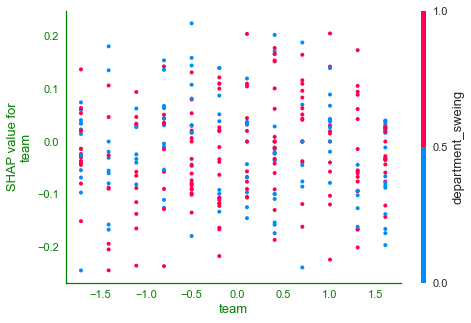

In [90]:
with plt.style.context('seaborn-white'):
    shap.dependence_plot('team',
                         shapval[0],
                         X_test_knn,
                         feature_names=X_test_knn.columns,
                         axis_color='green')

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


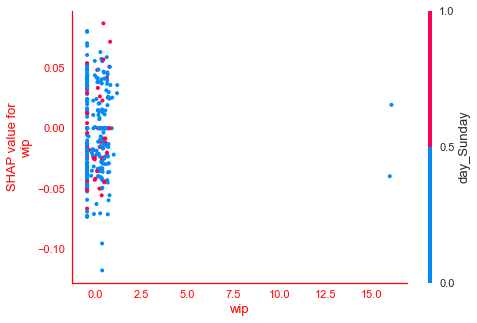

In [92]:
with plt.style.context('seaborn-white'):
    shap.dependence_plot('wip',
                         shapval[0],
                         X_test_knn,
                         feature_names=X_test_knn.columns,
                         axis_color='red')

## Other models tried

### ensemble methods

In [ ]:
X_train_ensbl, X_test_ensbl = fun.dataset_preprocessing_pipeline(X_train, X_test)

#### RandomForest<sup>TM</sup> grid search with Cross Validation

In [75]:
rf_clf_gs = RandomForestClassifier(n_jobs=-1)
params = {
    'criterion': ["gini", "entropy"],
    'max_depth': [2, 3, 4, None],
    'min_samples_leaf': [1, 2, 3, 4],
    'class_weight': ["balanced", "balanced_subsample"]
}
gridsearch_rf_clf = GridSearchCV(estimator=rf_clf_gs,
                                 param_grid=params,
                                 n_jobs=-1,
                                 scoring='precision')
gridsearch_rf_clf

GridSearchCV(estimator=RandomForestClassifier(n_jobs=-1), n_jobs=-1,
             param_grid={'class_weight': ['balanced', 'balanced_subsample'],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 4, None],
                         'min_samples_leaf': [1, 2, 3, 4]},
             scoring='precision')

Best Parameters by gridsearch:	{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1}
Best Estimator by gridsearch:	RandomForestClassifier(class_weight='balanced', criterion='entropy', n_jobs=-1)


******************************************************************************************
Train accuracy score: 1.0
Test accuracy score: 1.0
    No over or underfitting detected, diffrence of scores did not cross 5% thresh hold.
******************************************************************************************

************************************************************
Classification report on train data of:
        RandomForestClassifier(class_weight='balanced', criterion='entropy', n_jobs=-1)
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       875
           1       1.00      1.00      1.00       875

    accuracy                           1.00      1750
   macro avg       1.00      1.00      1.00      1750
weighted avg       1.00      1.00      1.00      1750

************************************************************


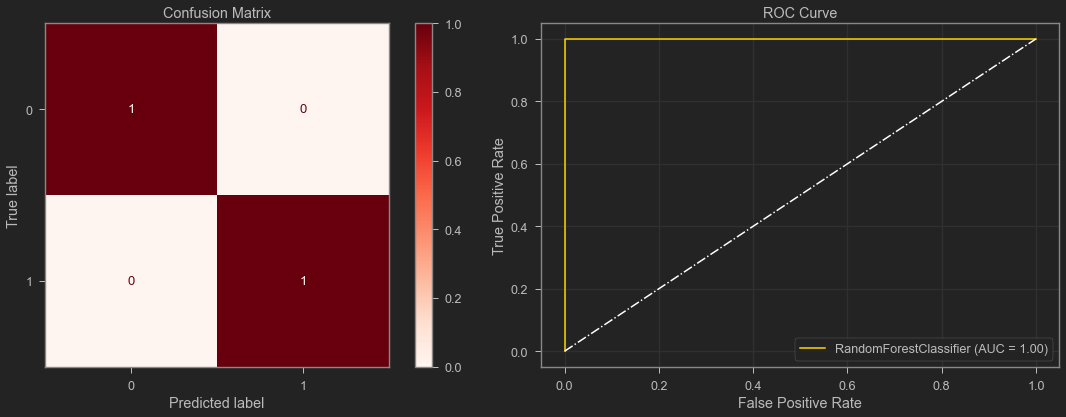

************************************************************
Classification report on test data of:
    RandomForestClassifier(class_weight='balanced', criterion='entropy', n_jobs=-1)
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        77
           1       1.00      1.00      1.00       223

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300

************************************************************


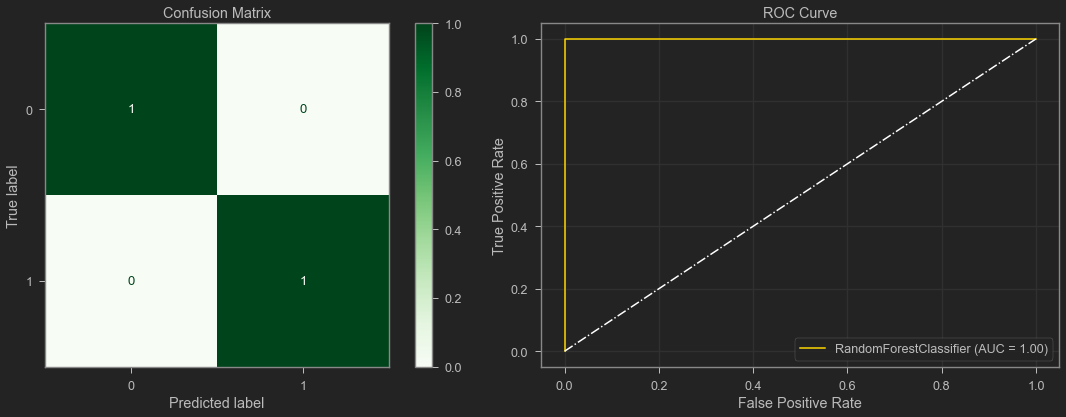

In [76]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    gridsearch_rf_clf.fit(X_train_ensbl, y_train)
print(f"Best Parameters by gridsearch:\t{gridsearch_rf_clf.best_params_}")
print(f"Best Estimator by gridsearch:\t{gridsearch_rf_clf.best_estimator_}")

rf_clf_gs_best = gridsearch_rf_clf.best_estimator_
fun.model_report(rf_clf_gs_best, X_train_ensbl, y_train, X_test_ensbl,
             y_test,show_train_report=True)

Performance drop can be if explained for different 'max_depth' because of the internal cross validation process hindering class imbalance of the train data which was not addressed by `class_weight='balanced'` parameter and trees were not allowed to expand as required.

#### XGBClassifier

******************************************************************************************
Train accuracy score: 0.992
Test accuracy score: 0.9867
    No over or underfitting detected, diffrence of scores did not cross 5% thresh hold.
******************************************************************************************

************************************************************
Classification report on test data of:
    XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, ve

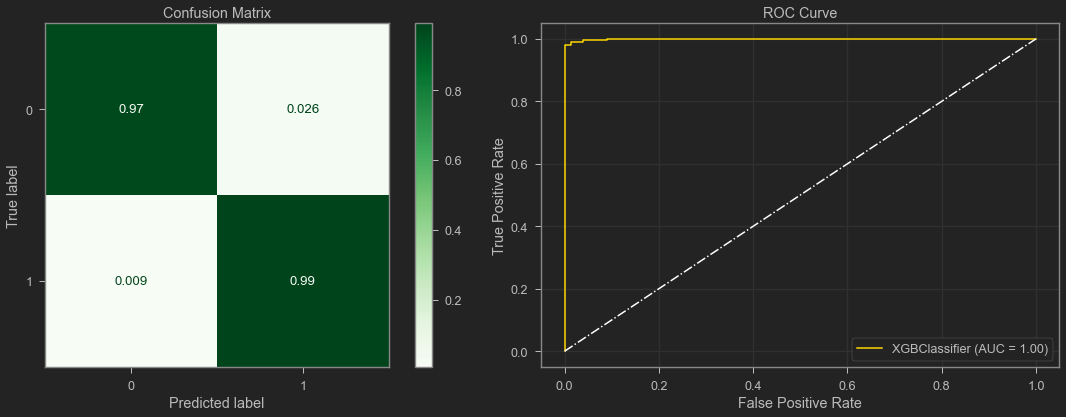

In [77]:
xgg_clf = XGBClassifier(n_jobs=-1)
fun.model_report(xgg_clf, X_train_ensbl, y_train, X_test_ensbl,
             y_test)

##### grid search with Cross Validation

In [ ]:
xgg_clf_gs = XGBClassifier(n_jobs=-1,verbosity=0,objective='binary:logistic',eval_metric='error')#“rank:pairwise”,“count:poisson” #'logloss','auc'
params = {
    'criterion': ["gini", "entropy"],
    'max_depth': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3, 4],
    'class_weight': ["balanced", "balanced_subsample"],
    'ccp_alpha': [0.0, 0.05, 0.1, 0.2, 0.3],
    'importance_type':["gain", "weight", "cover", "total_gain","total_cover"],
}
gridsearch_xgg_clf_gs = GridSearchCV(estimator=xgg_clf_gs,
                                 param_grid=params,
                                 n_jobs=-1,
                                 scoring='precision')  #'roc_auc_ovr_weighted'
gridsearch_xgg_clf_gs

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    gridsearch_xgg_clf_gs.fit(X_train_ensbl, y_train)
#     print(f"Best Parameters by gridsearch:\t{gridsearch_xgg_clf_gs.best_params_}")
#     print(f"Best Estimator by gridsearch:\t{gridsearch_xgg_clf_gs.best_estimator_}")
    
    
    xgg_clf_gs_best = gridsearch_xgg_clf_gs.best_estimator_
    xgb.plot_importance(xgg_clf_gs_best)
    fun.model_report(xgg_clf_gs_best, X_train_ensbl, y_train, X_test_ensbl,
                 y_test)

#### XGBRFClassifier

In [ ]:
xgg_rf_clf = XGBRFClassifier()
fun.model_report(xgg_rf_clf, X_train_ensbl, y_train, X_test_ensbl,
             y_test)

##### grid search with Cross Validation

In [ ]:
xgg_rf_clf_gs = XGBRFClassifier(
    n_jobs=-1,
    verbosity=0,
    objective='binary:logistic',
)  #“rank:pairwise”,“count:poisson” #'logloss','auc','error'
# params = {
#     'criterion': ["gini", "entropy"],
#     'max_depth': [2, 3, 4],
#     'min_samples_leaf': [1, 2, 3, 4],
#     'class_weight': ["balanced", "balanced_subsample"],
#     'ccp_alpha': [0.0, 0.01]
# }
params = {
    'criterion': ["gini", "entropy"],
    'max_depth': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3, 4],
    'class_weight': ["balanced", "balanced_subsample"],
    'ccp_alpha': [0.0, 0.05, 0.1, 0.2, 0.3],
    'importance_type':
    ["gain", "weight", "cover", "total_gain", "total_cover"],
    'eval_metric': ['logloss', 'auc', 'error']
}
gridsearch_xgg_rf_clf = GridSearchCV(
    estimator=xgg_rf_clf_gs,
    param_grid=params,
    n_jobs=-1,
    scoring='roc_auc')  #'roc_auc_ovr_weighted'
gridsearch_xgg_rf_clf

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    gridsearch_xgg_rf_clf.fit(X_train_ensbl, y_train)
#     print(f"Best Parameters by gridsearch:\t{gridsearch_xgg_rf_clf.best_params_}")
#     print(f"Best Estimator by gridsearch:\t{gridsearch_xgg_rf_clf.best_estimator_}")

    xgg_rf_clf_gs_best = gridsearch_xgg_rf_clf.best_estimator_
    xgb.plot_importance(xgg_rf_clf_gs_best)
    fun.model_report(xgg_rf_clf_gs_best, X_train_ensbl, y_train, X_test_ensbl,
                 y_test)

#### catboost

In [ ]:
model = CatBoostClassifier(task_type='GPU',
                           auto_class_weights='SqrtBalanced',
                           eval_metric='Precision',
                           devices=[0, 1],
                           min_data_in_leaf=3,
                           iterations=500)

#### Abailable options for `eval_metric` ####
# 'Logloss', 'CrossEntropy', 'CtrFactor', 'RMSE', 'Lq', 'MAE', 'Quantile',
# 'Expectile', 'LogLinQuantile', 'MAPE', 'Poisson', 'MSLE',
# 'MedianAbsoluteError', 'SMAPE', 'Huber', 'Tweedie', 'RMSEWithUncertainty',
# 'MultiClass', 'MultiClassOneVsAll', 'PairLogit', 'PairLogitPairwise',
# 'YetiRank', 'YetiRankPairwise', 'QueryRMSE', 'QuerySoftMax',
# 'QueryCrossEntropy', 'StochasticFilter', 'StochasticRank',
# 'PythonUserDefinedPerObject', 'PythonUserDefinedMultiRegression',
# 'UserPerObjMetric', 'UserQuerywiseMetric', 'R2', 'NumErrors', 'FairLoss',
# 'AUC', 'Accuracy', 'BalancedAccuracy', 'BalancedErrorRate', 'BrierScore',
# 'Precision', 'Recall', 'F1', 'TotalF1', 'MCC', 'ZeroOneLoss',
# 'HammingLoss', 'HingeLoss', 'Kappa', 'WKappa', 'LogLikelihoodOfPrediction',
# 'NormalizedGini', 'PRAUC', 'PairAccuracy', 'AverageGain', 'QueryAverage',
# 'QueryAUC', 'PFound', 'PrecisionAt', 'RecallAt', 'MAP', 'NDCG', 'DCG',
# 'FilteredDCG', 'MultiRMSE', 'Combination'

cat_features = list(X_train.select_dtypes('category').columns)

model.fit(X_train,
          y_train,
          cat_features=cat_features,
          eval_set=(X_test, y_test),
          plot=True,
          silent=True,
          use_best_model=True)
print(f'{"-"*90}')
train = model.score(X_train, y_train)
test = model.score(X_test, y_test)
print(f"""Train score: {train.round(4)}""")
print(f"""Test score: {test.round(4)}""")
print(f"")
print(metrics.classification_report(y_test, model.predict(X_test)))
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
metrics.plot_confusion_matrix(model,
                              X_test,
                              y_test,
                              cmap='Greens',
                              normalize='true',
                              ax=ax[0])
ax[0].title.set_text('Confusion Matrix')
metrics.plot_roc_curve(model, X_test, y_test, color='gold', ax=ax[1])
ax[1].plot([0, 1], [0, 1], ls='-.', color='white')
ax[1].grid()
ax[1].title.set_text('ROC Curve')

plt.tight_layout()
plt.show()

In [55]:
##### grid search with Cross Validation

In [56]:
# from sklearn.metrics import make_scorer, accuracy_score, recall_score, precision_score,precision_recall_curve, f1_score

# with warnings.catch_warnings():
#     warnings.simplefilter("ignore")
#     clf = CatBoostClassifier(task_type='GPU', iterations=2)
#     params = {
#         'eval_metric': ['Precision', 'Accuracy', 'Recall', 'AUC', 'F1'],
#         'depth': [4, 5, 6],
#         'loss_function': ['Logloss', 'CrossEntropy'],
#         'l2_leaf_reg': [1, 3, 5, 7, 9],
#         'auto_class_weights': ['SqrtBalanced', 'Balanced', None],
#         'leaf_estimation_method': ['Newton', 'Gradient'],
#         'logging_level': ['Silent']
#     }
#     scorer = make_scorer(f1_score)
#     clf_grid = GridSearchCV(estimator=clf,
#                             param_grid=params,
#                             scoring=scorer,
#                             cv=5)
#     clf_grid.fit(X_train_ensbl, y_train)
#     print(clf_grid.best_params_)
#     clf_grid_best = clf_grid.best_estimator_
#     fun.model_report(clf_grid_best, X_train_ensbl, y_train, X_test_ensbl,
#                      y_test)
    
# # create pool, then pass to frid search
# model.grid_search()

### Support Vector Machines

In [ ]:
X_train_svm, X_test_svm  = fun.dataset_preprocessing_pipeline(X_train, X_test)

#### lin

In [ ]:
svc_linear = SVC(kernel='linear', C=100,class_weight='balanced')
fun.model_report(svc_linear, X_train_svm, y_train, X_test_svm,
             y_test)

#### rbf

In [ ]:
svc_rbf = SVC(kernel='rbf', C=1, gamma='auto', class_weight='balanced', tol=.8)
fun.model_report(svc_rbf, X_train_svm, y_train, X_test_svm,
             y_test)

#### poly 

In [ ]:
svc_poly = SVC(kernel='poly',
               degree=8,
               C=1,
               gamma='scale',
               class_weight='balanced')
fun.model_report(svc_poly, X_train_svm, y_train, X_test_svm,
             y_test)

#### sigmoid

In [ ]:
svc_sig = SVC(kernel='sigmoid', C=2, class_weight='balanced')
fun.model_report(svc_sig, X_train_svm, y_train, X_test_svm,
             y_test)

#### grid search with Cross Validation

In [ ]:
svc_linear_gs = SVC(class_weight="balanced")
params = {
    'C': [1, 10, 1e2, 1e3],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto'],
    'tol': [0.001, .5, 1, 5],
}
gridsearch_svc_linear = GridSearchCV(
    estimator=svc_linear_gs,
    param_grid=params,
    n_jobs=-1,
    scoring='roc_auc')  #'roc_auc_ovr_weighted'
gridsearch_svc_linear

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    gridsearch_svc_linear.fit(X_train_svm, y_train)
print(f"Best Parameters by gridsearch:\t{gridsearch_svc_linear.best_params_}")
print(f"Best Estimator by gridsearch:\t{gridsearch_svc_linear.best_estimator_}")

svc_linear_gs_best = gridsearch_svc_linear.best_estimator_
fun.model_report(svc_linear_gs_best, X_train_svm, y_train, X_test_svm,
             y_test)